In [750]:
# !pip install --upgrade pandas==2.2.2 category_encoders==2.6.3 shap==0.45.1 scikit-learn==1.4.0

In [751]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import shap
import sklearn



In [752]:
pd.__version__,shap.__version__,np.__version__,sns.__version__,sklearn.__version__

('2.2.2', '0.45.1', '1.26.4', '0.13.2', '1.4.0')

In [753]:
import category_encoders
from category_encoders import TargetEncoder

category_encoders.__version__


'2.6.3'

## 0.0 Function Definition
### .1 show_missing_value_counts
### .2 get_df_categorical_cols_cardinalities
### .3 visualiseValueCountsProportions
### .4 getValueCounts
### .5 visualiseValuesAvgDts
### .6 visualiseCorrelationUsingBarChart
### .7 fill_missing_vals
### .8 fill_missing_vals_groupedby

In [754]:
# simple func to show number of missing values

def show_missing_value_counts(df):
    return df.isna().sum()


# Function to get cardinality numbers for each categorical column of a given dataset.
def get_df_categorical_cols_cardinalities(df):
    return df.select_dtypes(include="object").nunique(dropna=False)


# Function to visualise unique value count proportions in a given column (Bar Chart)
def visualiseValueCountsProportions(df, colName, title=""):
    if title == "":
        title = colName
    fig, ax = plt.subplots()
    df[colName].value_counts(normalize=True, dropna=False).sort_values(
        ascending=True
    ).plot(kind="barh", ax=ax)
    ax.set_ylabel(colName)
    ax.set_facecolor("white")
    ax.set_xlabel("Proportion")
    ax.set_title(f"{title} Distribution")


# Same function but no chart.
def getValueCounts(df, colName):
    return df[colName].value_counts(dropna=False).sort_values(ascending=True)


# Function to visualise Avg DTS for each unique value in a given column (Bar Chart)
def visualiseValuesAvgDts(df, colName):
    ax = (
        df.groupby(colName)["days_to_sell"]
        .mean()
        .sort_values(ascending=True)
        .plot(kind="bar", ylabel="DTS", title=f"Avg DTS vs {colName}")
    )
def visualiseCorrelationUsingBarChart(df, srcCol, trgCol):
    
    srcDf = pd.get_dummies(data=df[[srcCol, trgCol]], dtype=int)
    fig, ax = plt.subplots()
    ax = srcDf.corr()[trgCol][1:].sort_values().plot(kind="bar")
    ax.set_title(f"{trgCol} Correlation with {srcCol}")




In [755]:
df = pd.read_csv("adverts.csv")
df = df.drop('public_reference', axis=1)
df.head()

,mileage,reg_code,standard_colour,standard_make,standard_model,vehicle_condition,year_of_registration,price,body_type,crossover_car_and_van,fuel_type
0,0.0,NaN,Grey,Volvo,XC90,NEW,NaN,73970,SUV,False,Petrol Plug-in Hybrid
1,108230.0,61,Blue,Jaguar,XF,USED,2011.0,7000,Saloon,False,Diesel
2,7800.0,17,Grey,SKODA,Yeti,USED,2017.0,14000,SUV,False,Petrol
3,45000.0,16,Brown,Vauxhall,Mokka,USED,2016.0,7995,Hatchback,False,Diesel
4,64000.0,64,Grey,Land Rover,Range Rover Sport,USED,2015.0,26995,SUV,False,Diesel


In [756]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 402005 entries, 0 to 402004
Data columns (total 11 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   mileage                401878 non-null  float64
 1   reg_code               370148 non-null  object 
 2   standard_colour        396627 non-null  object 
 3   standard_make          402005 non-null  object 
 4   standard_model         402005 non-null  object 
 5   vehicle_condition      402005 non-null  object 
 6   year_of_registration   368694 non-null  float64
 7   price                  402005 non-null  int64  
 8   body_type              401168 non-null  object 
 9   crossover_car_and_van  402005 non-null  bool   
 10  fuel_type              401404 non-null  object 
dtypes: bool(1), float64(2), int64(1), object(7)
memory usage: 31.1+ MB


In [757]:
df.describe()

,mileage,year_of_registration,price
count,401878.000000,368694.000000,4.020050e+05
mean,37743.595656,2015.006206,1.734197e+04
std,34831.724018,7.962667,4.643746e+04
min,0.000000,999.000000,1.200000e+02
25%,10481.000000,2013.000000,7.495000e+03
50%,28629.500000,2016.000000,1.260000e+04
75%,56875.750000,2018.000000,2.000000e+04
max,999999.000000,2020.000000,9.999999e+06


In [758]:
df.isna().sum()

mileage                    127
reg_code                 31857
standard_colour           5378
standard_make                0
standard_model               0
vehicle_condition            0
year_of_registration     33311
price                        0
body_type                  837
crossover_car_and_van        0
fuel_type                  601
dtype: int64

## 1.1. Meaning and Type of Features
First we will show categorical and numerical features separately

In [759]:
categorical_columns = df.select_dtypes(include=['object']).columns
numerical_columns = df.select_dtypes(exclude=['object']).columns

In [760]:
df[categorical_columns].head()

,reg_code,standard_colour,standard_make,standard_model,vehicle_condition,body_type,fuel_type
0,NaN,Grey,Volvo,XC90,NEW,SUV,Petrol Plug-in Hybrid
1,61,Blue,Jaguar,XF,USED,Saloon,Diesel
2,17,Grey,SKODA,Yeti,USED,SUV,Petrol
3,16,Brown,Vauxhall,Mokka,USED,Hatchback,Diesel
4,64,Grey,Land Rover,Range Rover Sport,USED,SUV,Diesel


In [761]:
unique_colours_count = len(df["standard_colour"].value_counts())
unique_manufacturers_count = len(df["standard_make"].value_counts())
unique_models_count = len(df["standard_model"].value_counts())
unique_body_types_count = len(df["body_type"].value_counts())
unique_fuel_types_count = len(df["fuel_type"].value_counts())

print("Unique Colors: ",unique_colours_count)
print("Unique Manufacturers: ",unique_manufacturers_count)
print("Unique Models: ",unique_models_count)
print("Unique Body Types: ",unique_body_types_count)
print("Unique Fuel Types: ",unique_fuel_types_count)

Unique Colors:  22
Unique Manufacturers:  110
Unique Models:  1168
Unique Body Types:  16
Unique Fuel Types:  9


### 1.1.1 Categorical features
Here we can see every categorical feature in our dataset

1. **reg_code** : 

    A two-digit age identifier, which changes twice a year, on 1 March and 1 September. The code is either the last two digits of the year itself, if issued between March and August, or else has 50 added to that value if issued between September and February the following year - [Source](https://en.wikipedia.org/wiki/Vehicle_registration_plates_of_the_United_Kingdom)

    Since we already have a "year_of_registration" feature which indicates the age of the car, this column seems to be redundant.

2. **standard_colour** :

    Colour of the car's body. There are **22 unique** car colours.

3. **standard_make** : 

    Manufacturer of the car. There are **110 unique** car manufacturers in our dataset. 

4. **standard_model** :

    Model of the vehichle. There are **1168 unique** car models in the dataset.

5. **vehicle_condition** :

    This feature indicates whether the vehichle is **brand new** or **used**. Since the values for this feature are binary, we'll map the values to 0-1 later in the preprocessing stage, making it a numerical feature.

6. **body_type** :

    Type of the car's body. There are **16 unique** values.

7. **fuel_type** :

    Type of the fuel the cars use. There are **9 unique** values.



In [762]:
df[numerical_columns].head()

,mileage,year_of_registration,price,crossover_car_and_van
0,0.0,NaN,73970,False
1,108230.0,2011.0,7000,False
2,7800.0,2017.0,14000,False
3,45000.0,2016.0,7995,False
4,64000.0,2015.0,26995,False


### 1.1.2 Numerical features

Now we move on to explain numerical features in our dataset. There are four numerical columns in the dataset. 

1. **mileage** :   

    Number of miles a car has travelled.

2. **year_of_registration** :

    Shows the year the car was manufactured.

3. **price** :

    Price of the car. This is our target column in our model building phase.

4. **crossover_car_and_van** :

    Whether the vehicle is a car-van crossover or not. These types of cars are also commonly referred to as "smaller SUVs" or "CUVs". This column has a boolean value and since we already have a "body_type" feature, this column needs to be merged with "body_type" column in the preprocessing stage.

### 1.1.3 Analysis of Distributions

We start by analysing the Dataframe as a whole.

In [763]:
df.describe().T.round(2)

,count,mean,std,min,25%,50%,75%,max
mileage,401878.0,37743.60,34831.72,0.0,10481.0,28629.5,56875.75,999999.0
year_of_registration,368694.0,2015.01,7.96,999.0,2013.0,2016.0,2018.00,2020.0
price,402005.0,17341.97,46437.46,120.0,7495.0,12600.0,20000.00,9999999.0


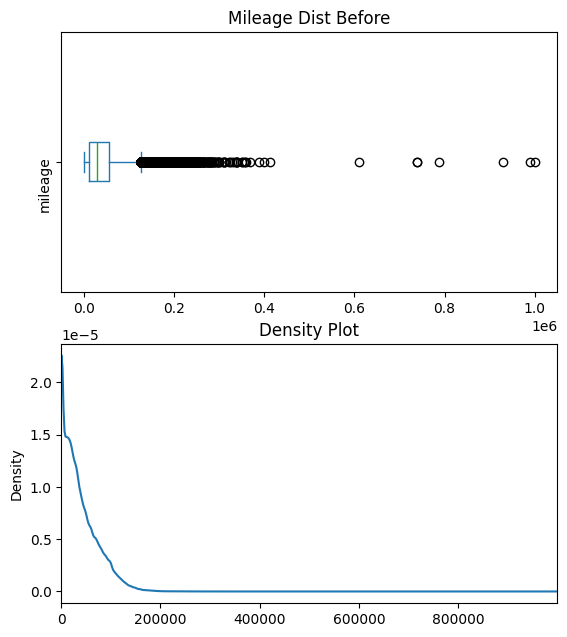

In [764]:
fig,(ax2,ax3) = plt.subplots(2,1)

df["mileage"].plot(kind='box',vert=False,ax=ax2,title="Mileage Dist Before",rot=90)
df["mileage"].plot(kind='density',ax=ax3,xlim=(0,df['mileage'].max()))
ax3.set_title("Density Plot")

plt.subplots_adjust(top=1.3)

By visualising the data using "Density" and "Box" charts we can clearly see that there are some outliers in our "mileage" column. For now we will ignore these to get a better visualisation and in the later phases we will drop them.

For removing the outliers we are going to use quantiles, meaning that we will ignore values higher than the 99.5 percentile.

In [765]:
df = (df[df["mileage"]<df["mileage"].quantile(.995)])
df["mileage"].describe()

count    399868.000000
mean      37000.182343
std       33115.228396
min           0.000000
25%       10378.750000
50%       28393.000000
75%       56000.000000
max      157900.000000
Name: mileage, dtype: float64

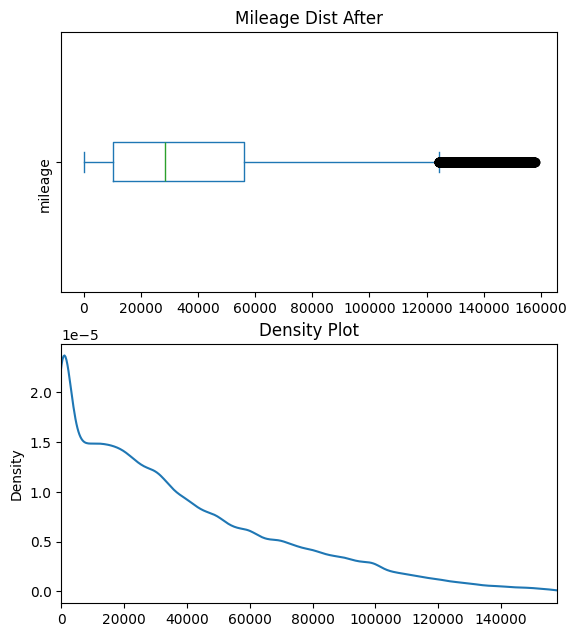

In [766]:
fig,(ax2,ax3) = plt.subplots(2,1)

df["mileage"].plot(kind='box',vert=False,ax=ax2,title="Mileage Dist After",rot=90)
df["mileage"].plot(kind='density',ax=ax3,xlim=(0,df['mileage'].max()))
ax3.set_title("Density Plot")



plt.subplots_adjust(top=1.3)

The density chart clearly shows that there are a large number of cars with 0 or close to 0 mileage. 

In [767]:
df["fuel_type"].value_counts(normalize=True,dropna=False).sort_values()

fuel_type
Diesel Plug-in Hybrid    0.000463
Bi Fuel                  0.000553
NaN                      0.001488
Diesel Hybrid            0.003494
Electric                 0.011956
Petrol Plug-in Hybrid    0.015405
Petrol Hybrid            0.033799
Diesel                   0.391454
Petrol                   0.541389
Name: proportion, dtype: float64

Text(0.5, 0, 'Proportion')

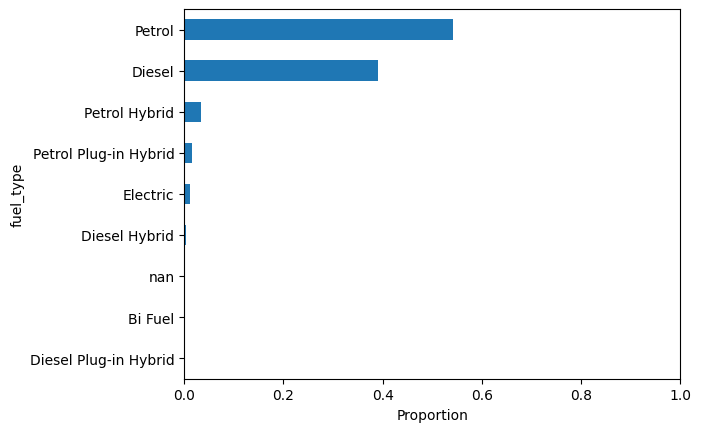

In [768]:
fig,ax = plt.subplots()
df["fuel_type"].value_counts(normalize=True,dropna=False).sort_values().plot(kind = 'barh',xlim=(0,1),ax=ax)
ax.set_xlabel("Proportion")


Fuel types are dominated by Petrol and Diesel as demonstrated by the chart. Since there are many types of hybrid fuel types each with insignificant number of cars, we will combine all hybrid types into one

In [769]:
df["fuel_type"]=df["fuel_type"].fillna(df["fuel_type"].mode()[0])
df.loc[df["fuel_type"].str.contains("Hybrid"),"fuel_type"]="Hybrid"
df = df[df["fuel_type"]!="Bi Fuel"]

In [770]:
df["fuel_type"].value_counts(normalize=True).sort_values()

fuel_type
Electric    0.011963
Hybrid      0.053189
Diesel      0.391671
Petrol      0.543177
Name: proportion, dtype: float64

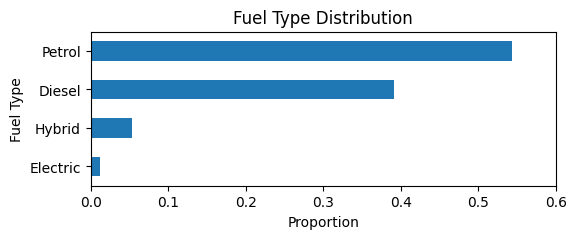

In [771]:
fig,ax = plt.subplots()
df["fuel_type"].value_counts(normalize=True,dropna=False).sort_values().plot(kind = 'barh',xlim=(0,.6),ax=ax,figsize=(6,2))
ax.set_xlabel("Proportion")
ax.set_ylabel("Fuel Type");
ax.set_title("Fuel Type Distribution");


Now we'll analyse the distribution of price

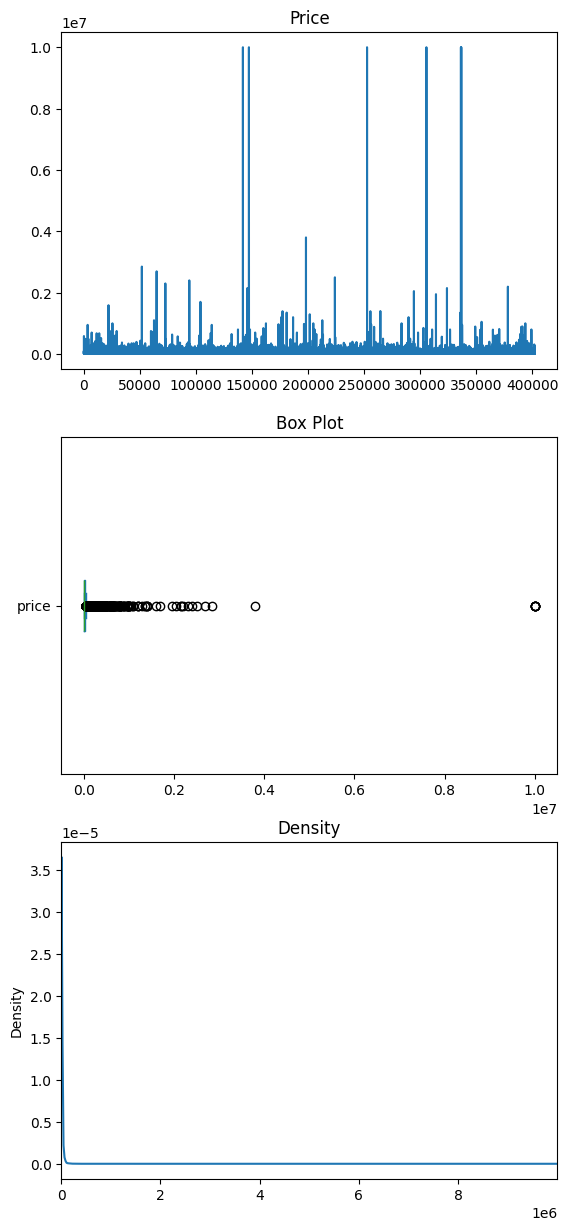

In [772]:
fig,(ax1,ax2,ax3) = plt.subplots(3,1)

df['price'].plot(ax=ax1)
ax1.set_title("Price")
df["price"].plot(kind='box',vert=False,ax=ax2)
ax2.set_title("Box Plot")
df["price"].plot(kind='density',ax=ax3,xlim=(0,df["price"].max()))
ax3.set_title("Density")

plt.subplots_adjust(top=2.5)

Same as mileage, we first have to ignore some outliers in order to be able to represent the data properly. We will use the same 99.5 percentile here as well.


In [773]:
df = (df[df["price"]<df["price"].quantile(.995)])

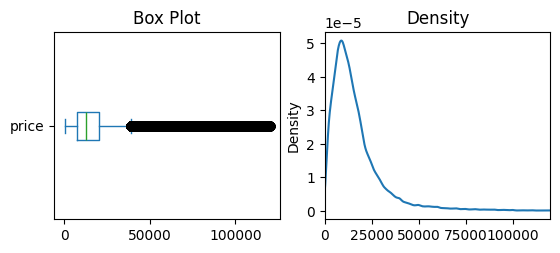

In [774]:
fig,(ax2,ax3) = plt.subplots(1,2)

df["price"].plot(kind='box',vert=False,ax=ax2)
ax2.set_title("Box Plot")
df["price"].plot(kind='density',ax=ax3,xlim=(0,df["price"].max()))
ax3.set_title("Density")
plt.subplots_adjust(top=.5)


In [775]:
df['price'].mean()

16218.493466386344

## 1.2 Analysis of Predictive Power of Features

### 1.2.1 Fuel Type : 
We will start by taking a closer look at the correlation between fuel_type and price. Since the number of cars with "Bi Fuel" and "Natural Gas" fuel types are both under 0.1% , we will drop them.

/var/folders/yb/614cxyhx0q3363qcs52dhljc0000gn/T/ipykernel_32088/714993822.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxenplot(x="fuel_type", y="price", data=df,palette="hls");


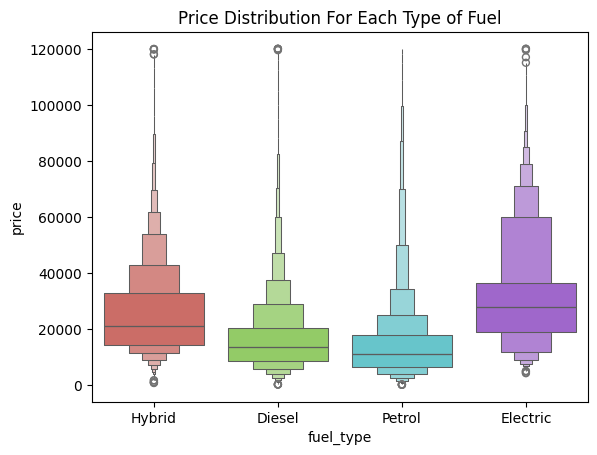

In [776]:
df = df[df["fuel_type"]!="Natural Gas"]
df = df[df["fuel_type"]!="Bi Fuel"]
sns.boxenplot(x="fuel_type", y="price", data=df,palette="hls");
plt.title("Price Distribution For Each Type of Fuel");

In [777]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 397636 entries, 0 to 402004
Data columns (total 11 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   mileage                397636 non-null  float64
 1   reg_code               366057 non-null  object 
 2   standard_colour        392472 non-null  object 
 3   standard_make          397636 non-null  object 
 4   standard_model         397636 non-null  object 
 5   vehicle_condition      397636 non-null  object 
 6   year_of_registration   364652 non-null  float64
 7   price                  397636 non-null  int64  
 8   body_type              396847 non-null  object 
 9   crossover_car_and_van  397636 non-null  bool   
 10  fuel_type              397636 non-null  object 
dtypes: bool(1), float64(2), int64(1), object(7)
memory usage: 41.8+ MB


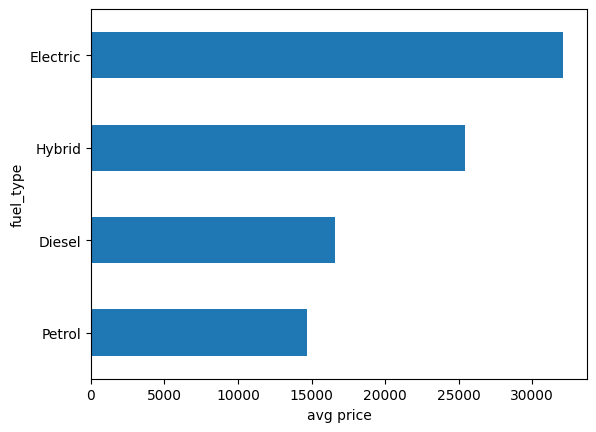

In [778]:
df.groupby('fuel_type').mean('price')['price'].sort_values().plot(kind='barh',xlabel="avg price");

We can clearly observe from our data that electric cars cost considerably more on average than other types of automobiles.


### 1.2.2 Mileage :
Now we will analyse the correlation between mileage and price of a car. 

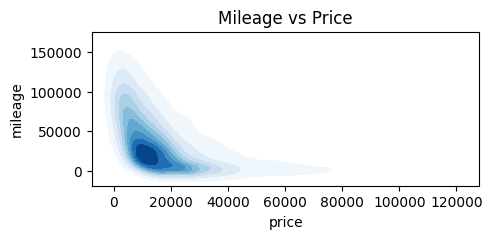

In [779]:

import matplotlib.ticker as mtick

sampled_df = df.sample(frac=0.05)
plt.figure(figsize=(5,2))
ax = sns.kdeplot(x='price', y='mileage', data=sampled_df, cmap='Blues', fill=True);
plt.title("Mileage vs Price");



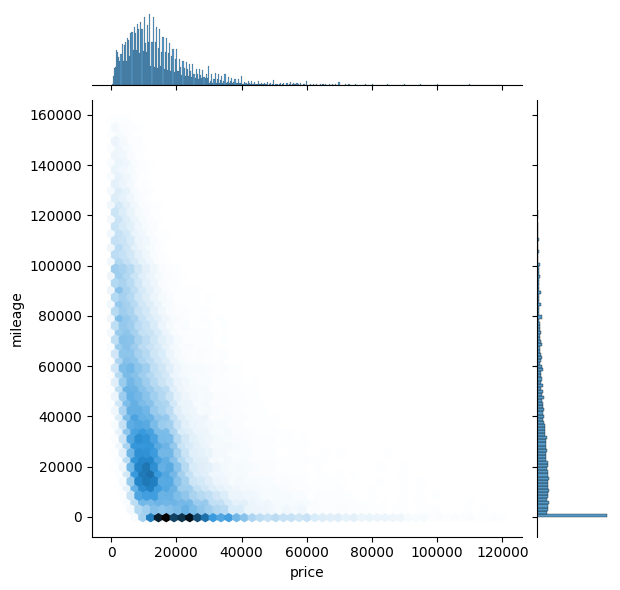

In [780]:
sns.jointplot(x='price', y='mileage', data=df, kind="hex");


We can clearly see from the charts and the correlation value that there's a strong negative correlation between mileage and price.

### 1.2.3 Vehicle Condition : 
Now we will analyse the correlation between price and condition of the vehicle. 

In [781]:
df.groupby('vehicle_condition').mean('price').round(1)

,mileage,year_of_registration,price,crossover_car_and_van
vehicle_condition,,,,
NEW,5.4,NaN,32739.4,0.0
USED,40309.3,2015.0,14819.2,0.0


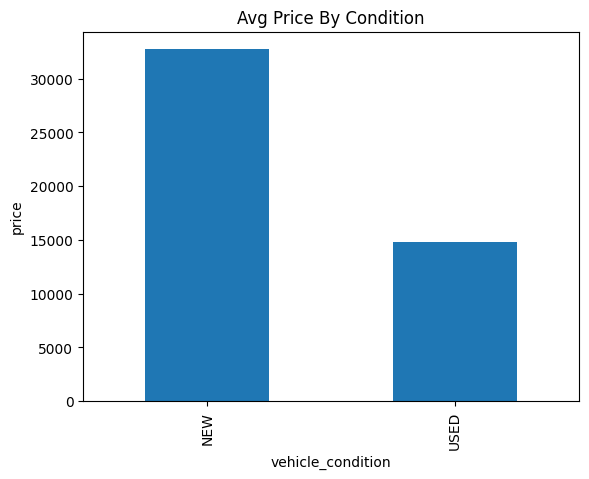

In [782]:
df.groupby('vehicle_condition').mean('price')["price"].plot(kind="bar",ylabel="price",title="Avg Price By Condition");


The data suggests that the average price of a New car is more than twice that of a Used one. 

## 1.3  Data Processing for Data Exploration and Visualisation

Some features in our data need more processing before they can be analysed or visualised properly. One such feature is "Fuel type" which we handled by reducing the total number of unique values from 9 to 4. Same should be done to more features like "Colour" and "Body type".

### 1.3.1 Colour :
This feature has a relatively high cardinality, at the same time it doesn't seem to be a crucial predicting factor in the price of car. We will try lowering the total number of unique colours by clumping the less significant ones in an "Other" category. There are also around 5k missing values in this column. we will analyse these missing values to find a relationship between them and other features namely whether these are linked to new cars or not. 

In [783]:
df["standard_colour"].isna().sum()

5164

In [784]:
df[df["standard_colour"].isna()]["vehicle_condition"].value_counts()

vehicle_condition
USED    4133
NEW     1031
Name: count, dtype: int64

The proportion of missing colour values in relation to vehicle conditon seems to be inline with dataset as a whole, So we will add them to the "other" category.

In [785]:
len(df['standard_colour'].value_counts(dropna=True))

22

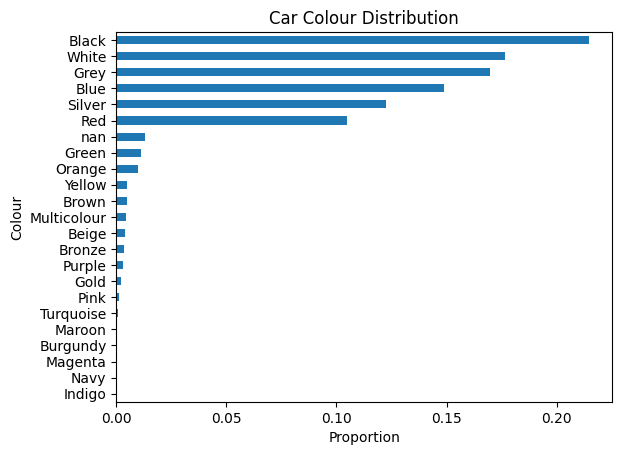

In [786]:
fig,ax = plt.subplots()
df['standard_colour'].value_counts(normalize=True,dropna=False).sort_values(ascending=True).plot(kind="barh",ax=ax)
ax.set_ylabel("Colour")
ax.set_xlabel("Proportion")
ax.set_title("Car Colour Distribution");

In [787]:
coloursCount = dict(df["standard_colour"].value_counts(normalize=True,dropna=False))
otherColoursList = []
for key,val in (coloursCount).items():
    if val < 0.1:
        otherColoursList.append(key)


In [788]:
df['standard_colour'] = df["standard_colour"].replace(otherColoursList,"Other")
df["standard_colour"].describe()

count     397636
unique         7
top        Black
freq       85304
Name: standard_colour, dtype: object

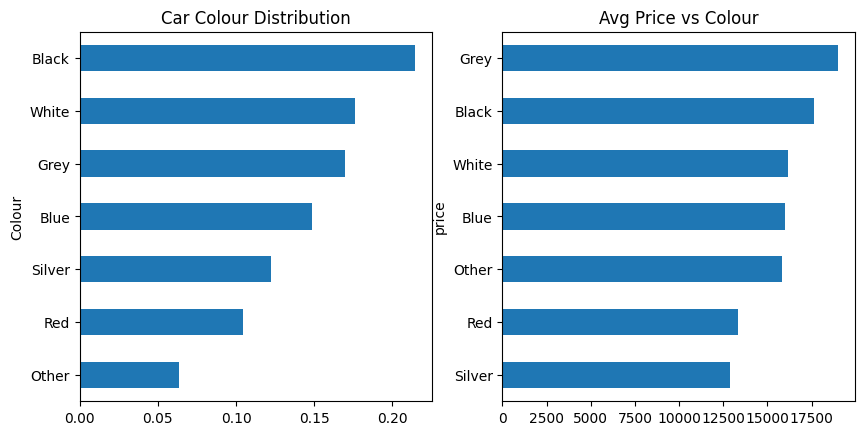

In [789]:
fig,(ax,ax1) = plt.subplots(1,2)
df['standard_colour'].value_counts(normalize=True,dropna=False).sort_values(ascending=True).plot(kind="barh",ax=ax)
ax.set_ylabel("Colour")
ax.set_title("Car Colour Distribution");
ax1 = df.groupby("standard_colour").mean('price')['price'].sort_values(ascending=True).plot(kind='barh',ylabel="price",title="Avg Price vs Colour");
fig.set_figwidth(10)

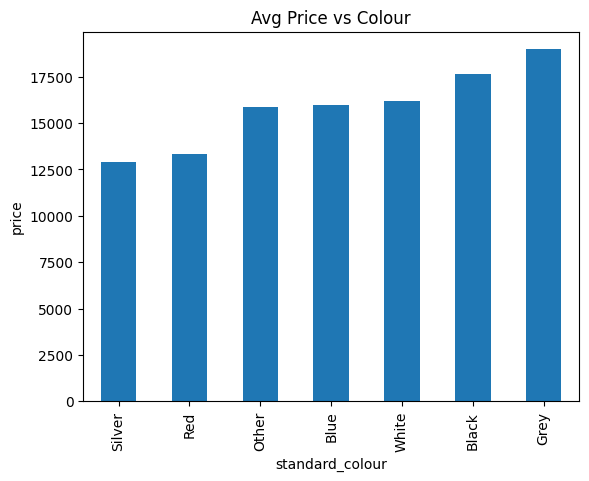

In [790]:
ax = df.groupby("standard_colour").mean('price')['price'].sort_values(ascending=True).plot(kind='bar',ylabel="price",title="Avg Price vs Colour");

### 1.3.2 Body Type : 
This feature also has a relatively high cardinality with some outliers but unlike colour it *IS* an important predictor of the price. There is also around 800 missing values which we will deal with.

In [791]:
df["body_type"].isna().sum()

789

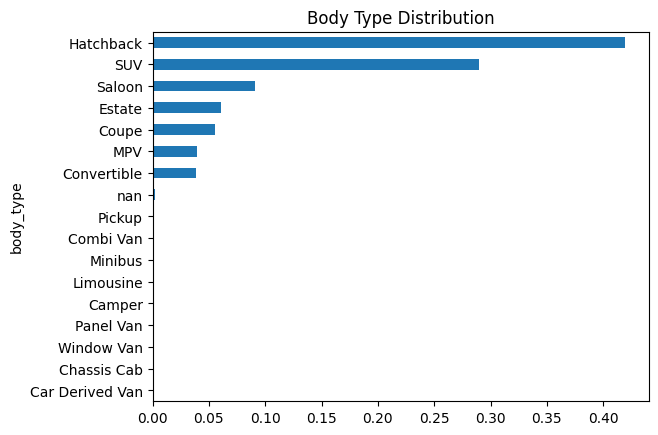

In [792]:
ax = df["body_type"].value_counts(dropna=False,normalize=True).sort_values(ascending=True).plot(kind="barh")
ax.set_title("Body Type Distribution");

In [793]:
body_type_count = dict(df["body_type"].value_counts(normalize=True,dropna=False))
other_body_type_list = []
for key,val in (body_type_count).items():
    if val < 0.04:
        other_body_type_list.append(key)


In [794]:
df["body_type"]=df["body_type"].replace(other_body_type_list,"Other")
df["body_type"].describe()

count        397636
unique            6
top       Hatchback
freq         166728
Name: body_type, dtype: object

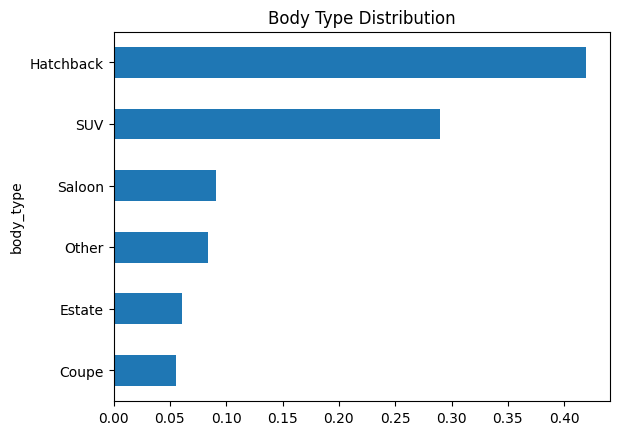

In [795]:
ax = df["body_type"].value_counts(dropna=False,normalize=True).sort_values(ascending=True).plot(kind="barh")
ax.set_title("Body Type Distribution");

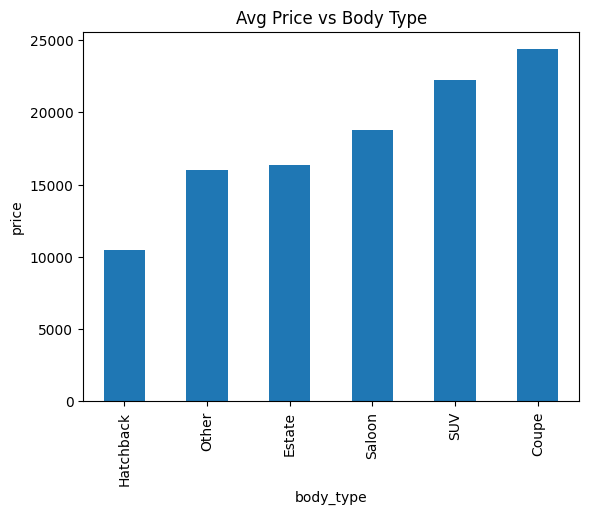

In [796]:
ax = df.groupby("body_type").mean('price')['price'].sort_values(ascending=True).plot(kind='bar',ylabel="price",title="Avg Price vs Body Type");


We have reduced the cardinality of this feature significantly. By adding an "Other" category we reduced the unique number of body types from 16 down to 6.

# 2 . Data Processing for Machine Learning

In [797]:
# MISSING VALUES IN THE RAW DATA
df_pre = pd.read_csv("adverts.csv")
df_pre = df_pre.drop('public_reference', axis=1)
df_pre.isna().sum()

mileage                    127
reg_code                 31857
standard_colour           5378
standard_make                0
standard_model               0
vehicle_condition            0
year_of_registration     33311
price                        0
body_type                  837
crossover_car_and_van        0
fuel_type                  601
dtype: int64

In [798]:
df_pre.isna().sum().sum()

72111

In [799]:
# MISSING VALUES THUS FAR
df.isna().sum()

mileage                      0
reg_code                 31579
standard_colour              0
standard_make                0
standard_model               0
vehicle_condition            0
year_of_registration     32984
price                        0
body_type                    0
crossover_car_and_van        0
fuel_type                    0
dtype: int64

In [800]:
df.isna().sum().sum()

64563

## 2.1 Dealing with Missing Values, Outliers and Noise

A significant amount of work has already been done in this regard in previous sections. these are some of them as a reminder:

1. We dealt with outliers in "mileage" and "price" by removing values higher than the 99.5 percentile. 

2. We dealt with data with insignificant values counts by adding them up with each other and creating an "Other" category in our features.

3. We dealt with missing values in "body_type", "fuel_type" and "standard_colour" by adding them to the "other" category.

By doing these steps we have cleaned up every feature from missing values other than "reg_code" and "year_of_registration" which we are going to work on in the next sections.

### 2.1.1 Year Of Registration : 
Before we start analysing the predictive power of this feature, we have to deal with the missing values in this column. There are approximately 33 thousand missing values in this column which is a considerable amount. But with the help of "vehicle_condition" column we can get some clues as to what these missing values could be.

In [801]:
df.isna().sum()

mileage                      0
reg_code                 31579
standard_colour              0
standard_make                0
standard_model               0
vehicle_condition            0
year_of_registration     32984
price                        0
body_type                    0
crossover_car_and_van        0
fuel_type                    0
dtype: int64

In [802]:
df[df.isna()["year_of_registration"]]["vehicle_condition"].value_counts()

vehicle_condition
NEW     31049
USED     1935
Name: count, dtype: int64

As we can see here, among the 33k missing values in this column, 31k of them are new cars. This means that most likely these missing values refer to cars that are yet to be registered. So logically the year of registration for these cars would be 2020 or even 2021 because the newest cars on our dataset are registered on 2020. So we will fill these missing values with 2021 to differentiate them with cars that are already registered. 

After doing so, only 1935 missing "year_of_registration" values remain in our dataset which amounts to less than 0.5% of our data, So we'll drop these values. 

In [803]:
df.loc[(df["year_of_registration"].isna()) & (df["vehicle_condition"]=="NEW"),"year_of_registration"] = 2021

In [804]:
df.isna().sum()

mileage                      0
reg_code                 31579
standard_colour              0
standard_make                0
standard_model               0
vehicle_condition            0
year_of_registration      1935
price                        0
body_type                    0
crossover_car_and_van        0
fuel_type                    0
dtype: int64

In [805]:
df = df.dropna(subset=["year_of_registration"])

In [806]:
df.isna().sum()

mileage                      0
reg_code                 31308
standard_colour              0
standard_make                0
standard_model               0
vehicle_condition            0
year_of_registration         0
price                        0
body_type                    0
crossover_car_and_van        0
fuel_type                    0
dtype: int64

Now we'll take a look at the range of the YoR values. we will drop cars that are too old as they are outliers in our data.

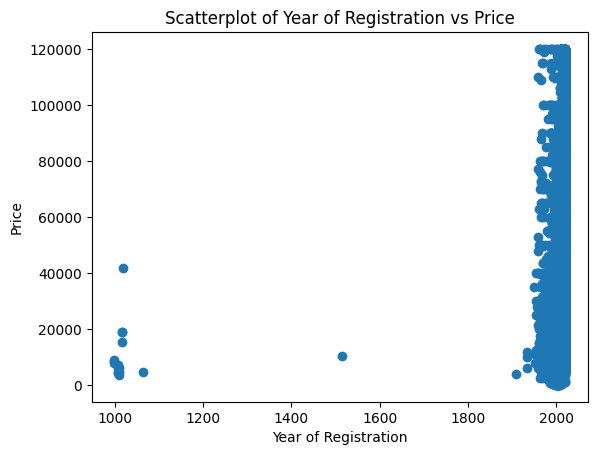

In [807]:
plt.scatter(df['year_of_registration'], df['price'])
plt.xlabel('Year of Registration')
plt.ylabel('Price')
plt.title('Scatterplot of Year of Registration vs Price')
plt.show()


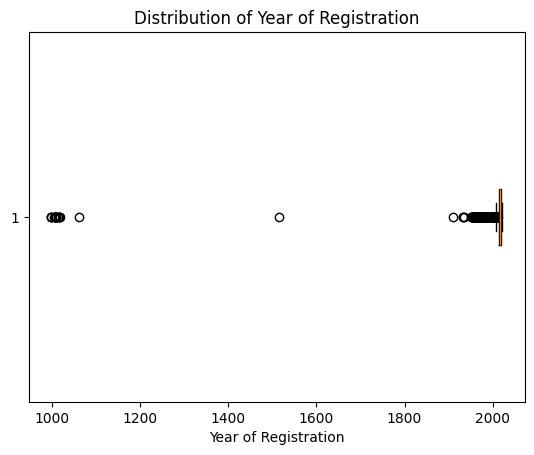

In [808]:
import matplotlib.pyplot as plt

plt.boxplot(df['year_of_registration'], vert=False)
plt.xlabel('Year of Registration')
plt.title('Distribution of Year of Registration')
plt.show()


In [809]:
print('number of rows to drop: ',len(df[df['year_of_registration']<=1980]))
df = df[df['year_of_registration']>1980]

df['year_of_registration'].describe()

number of rows to drop:  299


count    395402.000000
mean       2015.589828
std           4.224315
min        1981.000000
25%        2014.000000
50%        2017.000000
75%        2018.000000
max        2021.000000
Name: year_of_registration, dtype: float64

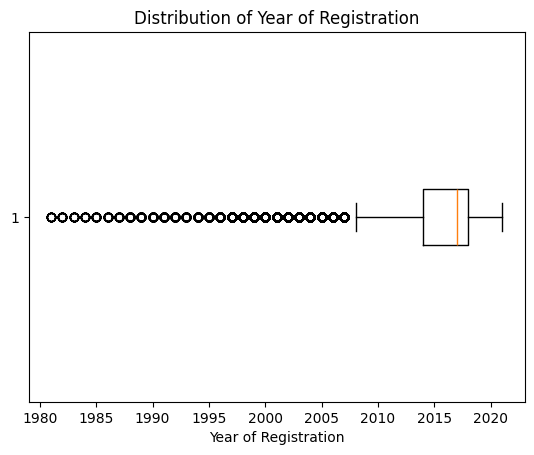

In [810]:
plt.boxplot(df['year_of_registration'], vert=False)
plt.xlabel('Year of Registration')
plt.title('Distribution of Year of Registration')
plt.show()

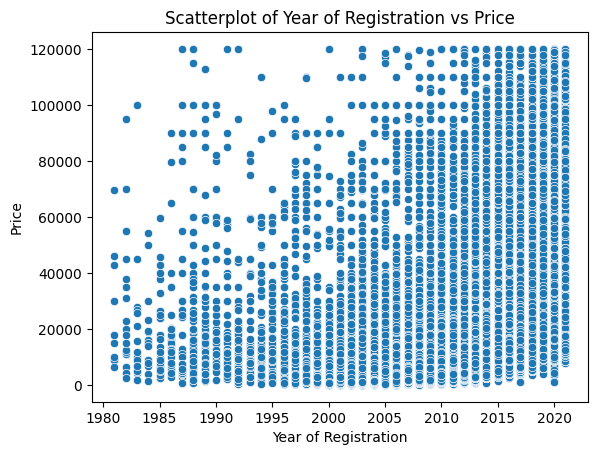

In [811]:
sns.scatterplot(x=df['year_of_registration'],y=df['price'])
plt.xlabel('Year of Registration')
plt.ylabel('Price')
plt.title('Scatterplot of Year of Registration vs Price')
plt.show()

### 2.1.2 Reg_Code :
Since Reg_code is a derivative of "year_of_registration" there is no point in keeping it in our dataset. By reading the wikipedia page on UK reg_code convention we can clearly conclude there's no point in keeping this feature.

In [812]:
df = df.drop('reg_code', axis=1)


### 2.1.3 standard_make

In [813]:
df['standard_make'].value_counts()


standard_make
BMW               36864
Audi              34848
Volkswagen        33691
Vauxhall          33465
Mercedes-Benz     31291
                  ...  
Panther               1
Plymouth              1
Reliant               1
Bristol               1
Custom Vehicle        1
Name: count, Length: 100, dtype: int64

In [814]:

# we will drop infrequent (less than THRESHOLD) car manufacturers from our data

len_with_model_outliers = df["standard_make"].count()

THRESHOLD = 50

model_counts_below_50 = dict(df["standard_make"].value_counts())
for key in (model_counts_below_50).copy():
    if model_counts_below_50[key] > THRESHOLD :
        del model_counts_below_50[key]

        
model_counts_below_50=list(model_counts_below_50.keys())

df=df[~df["standard_make"].isin(model_counts_below_50)]
len_without_make_model_outliers = df['standard_make'].count()

print("Number of Dropped Rows: "+str(len_with_model_outliers-len_without_make_model_outliers))

Number of Dropped Rows: 414


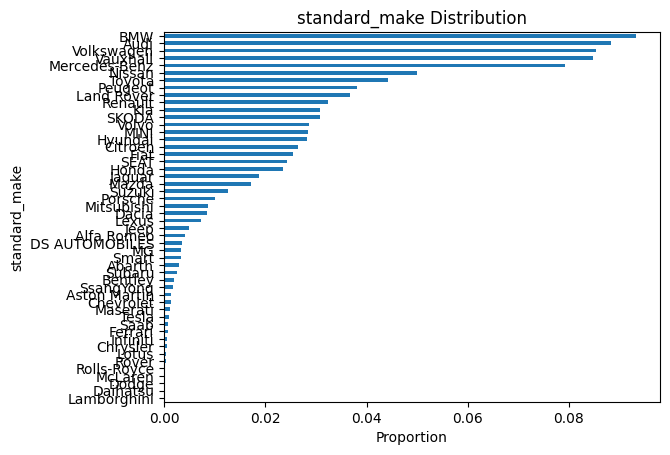

In [815]:
visualiseValueCountsProportions(df,'standard_make')

### 2.1.4 standard_model 

In [816]:
print("cardinality of models before dropping infrequent models: ")
df['standard_model'].value_counts().count()

cardinality of models before dropping infrequent models: 


951

In [817]:
print('Num of rows to be dropped:')
THRESHOLD = 50

df['standard_model'].value_counts().where(df['standard_model'].value_counts()<=THRESHOLD).dropna().sum()

Num of rows to be dropped:


5941.0

In [818]:
len_with_model_outliers = df["standard_model"].count()

model_counts_below_50 = dict(df["standard_model"].value_counts())
for key in (model_counts_below_50).copy():
    if model_counts_below_50[key] > THRESHOLD :
        del model_counts_below_50[key]

model_counts_below_50=list(model_counts_below_50.keys())

df=df[~df["standard_model"].isin(model_counts_below_50)]

In [819]:
len_without_make_model_outliers = df['standard_model'].count()

print("Number of Dropped Rows: "+str(len_with_model_outliers-len_without_make_model_outliers))

Number of Dropped Rows: 5941


In [820]:
print("cardinality of models after dropping infrequent models: ")
df['standard_model'].value_counts().count()

cardinality of models after dropping infrequent models: 


449

## 2.2 Feature Engineering, Data Transformations, Feature Selection :



### 2.2.1 Vehicle Condition : 
Since this feature has binary values ("NEW","USED"), we will replace them with (1,0).

In [821]:
df["vehicle_condition"]=df["vehicle_condition"].replace(["USED","NEW"],[0,1])


/var/folders/yb/614cxyhx0q3363qcs52dhljc0000gn/T/ipykernel_32088/2123511080.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df["vehicle_condition"]=df["vehicle_condition"].replace(["USED","NEW"],[0,1])


In [822]:
df.head()

,mileage,standard_colour,standard_make,standard_model,vehicle_condition,year_of_registration,price,body_type,crossover_car_and_van,fuel_type
0,0.0,Grey,Volvo,XC90,1,2021.0,73970,SUV,False,Hybrid
1,108230.0,Blue,Jaguar,XF,0,2011.0,7000,Saloon,False,Diesel
2,7800.0,Grey,SKODA,Yeti,0,2017.0,14000,SUV,False,Petrol
3,45000.0,Other,Vauxhall,Mokka,0,2016.0,7995,Hatchback,False,Diesel
4,64000.0,Grey,Land Rover,Range Rover Sport,0,2015.0,26995,SUV,False,Diesel


### 2.2.2 Crossover_car_van : 
As already mentioned in section 1.1.2:

"Whether the vehicle is a car-van crossover or not. These types of cars are also commonly referred to as "smaller SUVs" or "CUVs". This column has a boolean value and since we already have a "body_type" feature, this column needs to be merged with "body_type" column." 

We could add a category named "CUV" in our "body_type" feature based on the value of this column, But since the number of these cars are insignificant compared to other body types, we will add them to the "Other" category. 

In [823]:
df.loc[(df["crossover_car_and_van"]==True)&(df["body_type"]=="Other"),"body_type"] = "CUV"

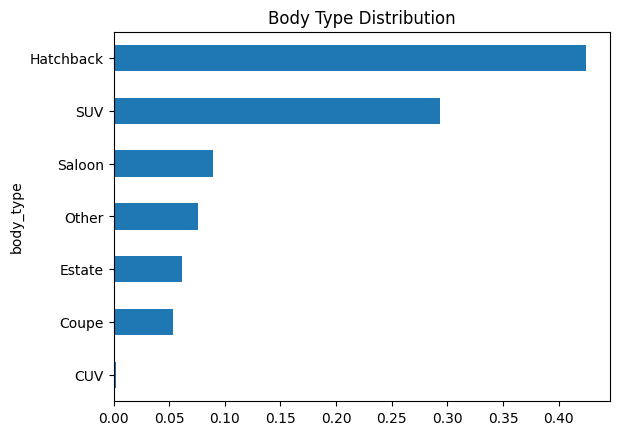

In [824]:
ax = df["body_type"].value_counts(dropna=False,normalize=True).sort_values(ascending=True).plot(kind="barh")
ax.set_title("Body Type Distribution");

"CUV"s are insignificant so we will add them to "Other" 

In [825]:
df.loc[df["body_type"]=="CUV","body_type"] = "Other"

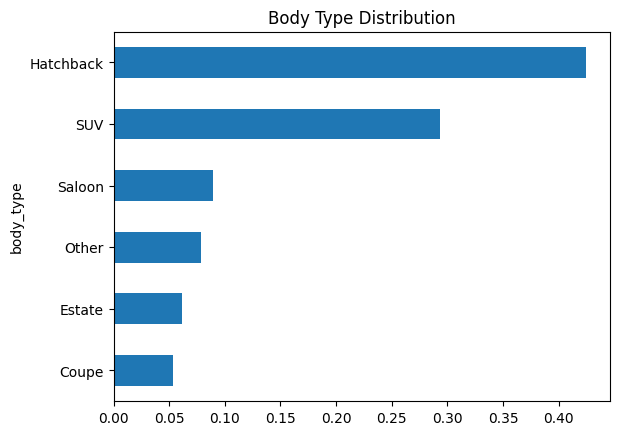

In [826]:
ax = df["body_type"].value_counts(dropna=False,normalize=True).sort_values(ascending=True).plot(kind="barh")
ax.set_title("Body Type Distribution");

Now we can safely remove the "crossover_car_and_van" column 

In [827]:
df = df.drop('crossover_car_and_van', axis=1)


### Luxury brands

we will create a new column for luxury cars based on their brand. if the mean price of the brand is higher than the 95% percentile then it's luxury.

In [828]:
df.head()

,mileage,standard_colour,standard_make,standard_model,vehicle_condition,year_of_registration,price,body_type,fuel_type
0,0.0,Grey,Volvo,XC90,1,2021.0,73970,SUV,Hybrid
1,108230.0,Blue,Jaguar,XF,0,2011.0,7000,Saloon,Diesel
2,7800.0,Grey,SKODA,Yeti,0,2017.0,14000,SUV,Petrol
3,45000.0,Other,Vauxhall,Mokka,0,2016.0,7995,Hatchback,Diesel
4,64000.0,Grey,Land Rover,Range Rover Sport,0,2015.0,26995,SUV,Diesel


In [829]:
luxury_brand_threshold = df['price'].quantile(.95)

make_mean_prices_dict = df.groupby(by=['standard_make'])['price'].mean().sort_values().to_dict()
luxury_brands =[]
for i in make_mean_prices_dict:
    if make_mean_prices_dict[i]>luxury_brand_threshold:
        luxury_brands.append(i)

df['is_luxury_brand'] = df['standard_make'].apply(lambda x: 1 if x in luxury_brands else 0)

### 2.2.3 : Spliting the Dataset into train/test : 

Now we move on to creating the Train/Test split for our dataset, we use the default 20% split.

In [830]:
# import ML models
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

# Import cross-validation and splitting methods
from sklearn.model_selection import KFold, cross_val_score, train_test_split

# Import modules for preprocessing and feature scaling
from sklearn.preprocessing import StandardScaler

# Import model evaluation tools
from sklearn import model_selection 
from sklearn import metrics
from sklearn.metrics import ConfusionMatrixDisplay, classification_report, r2_score, mean_squared_error, mean_absolute_error, accuracy_score,root_mean_squared_error

# Import modules for hyperparameter tuning
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

seed = 42

In [831]:
get_df_categorical_cols_cardinalities(df)

standard_colour      7
standard_make       43
standard_model     449
body_type            6
fuel_type            4
dtype: int64

In [832]:
categorical_columns_target_encoder = ["standard_colour","standard_make",'standard_model',"body_type","fuel_type"]

In [833]:
X = df.drop('price', axis=1)
y = (df['price'])

In [834]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = seed)
print("X_train shape: ", X_train.shape, "; y_train shape: ", y_train.shape)
print("X_test shape: ", X_test.shape, "; y_test shape: ", y_test.shape) 

X_train shape:  (311237, 9) ; y_train shape:  (311237,)
X_test shape:  (77810, 9) ; y_test shape:  (77810,)


In [835]:
X_train['price'] = y_train
reverse_encode_maps = {}
for i in categorical_columns_target_encoder:
    reverse_encode_maps[i]=(X_train.groupby(i)['price'].mean().round(1).to_dict())
X_train=X_train.drop(columns='price')

reverse_encode_maps.keys()

dict_keys(['standard_colour', 'standard_make', 'standard_model', 'body_type', 'fuel_type'])

In [836]:
reverse_encode_maps['fuel_type']

{'Diesel': 16658.2, 'Electric': 31654.5, 'Hybrid': 25467.7, 'Petrol': 14379.1}

### Encoding the data : 
Since "fuel_type" has relatively low cardinality, we use One_Hot_Encoding to encode the values in the column. But for the rest of the features we use target_encoder since they have high cardinality. In order to avoid data leakage we made sure to fit our transformers only on our train data.  

In [837]:
from category_encoders import TargetEncoder,HashingEncoder
from sklearn.preprocessing import OneHotEncoder

In [838]:
# one_hot_encoder = OneHotEncoder(
#     sparse_output=False
# ).set_output(transform='pandas')

In [839]:
# categorical_columns_ohe = ["fuel_type"]

In [840]:
# one_hot_encoder.fit(X_train[categorical_columns_ohe])
# X_train = X_train.join(one_hot_encoder.transform(X_train[categorical_columns_ohe]),lsuffix="",rsuffix="_ohe")
# X_test = X_test.join(one_hot_encoder.transform(X_test[categorical_columns_ohe]),lsuffix="",rsuffix="_ohe")
# X_train = X_train.drop(categorical_columns_ohe, axis=1)
# X_test = X_test.drop(categorical_columns_ohe, axis=1)


In [841]:
df.shape

(389047, 10)

In [842]:
X_test.shape , X_train.shape

((77810, 9), (311237, 9))

In [843]:
def encode_and_bind(original_dataframe, feature_to_encode):
    dummies = pd.get_dummies(original_dataframe[[feature_to_encode]])
    res = pd.concat([original_dataframe, dummies], axis=1)
    res = res.drop([feature_to_encode], axis=1)
    return(res) 

In [844]:
categorical_columns_target_encoder

['standard_colour',
 'standard_make',
 'standard_model',
 'body_type',
 'fuel_type']

In [845]:
from sklearn.preprocessing import LabelEncoder

target_encoder = TargetEncoder()

In [846]:
target_encoder.fit(X_train[categorical_columns_target_encoder], y_train)
X_train = X_train.join(target_encoder.transform(X_train[categorical_columns_target_encoder]),lsuffix="",rsuffix="_enc") 
X_test = X_test.join(target_encoder.transform(X_test[categorical_columns_target_encoder]),lsuffix="",rsuffix="_enc") 
X_train = X_train.drop(categorical_columns_target_encoder, axis=1)
X_test = X_test.drop(categorical_columns_target_encoder, axis=1)


In [847]:
feature_names = X_train.columns

### scaling the data

In [848]:
# Scaling the X predictors
scaler = StandardScaler().set_output(transform='pandas')  # instantiate scaler
X_train = scaler.fit_transform(X_train)  # fit scaler to the training data
X_test = scaler.transform(X_test)  # only transform the test data

In [849]:
X_train

,mileage,vehicle_condition,year_of_registration,is_luxury_brand,standard_colour_enc,standard_make_enc,standard_model_enc,body_type_enc,fuel_type_enc
326376,-0.661202,-0.292871,0.570069,-0.121368,-0.004222,-0.405222,-0.314944,-1.067858,-0.558224
36968,-0.814883,-0.292871,0.817442,-0.121368,0.728486,0.626762,0.325618,1.367806,0.189247
329147,1.473624,-0.292871,-2.645787,-0.121368,-0.298504,-0.656840,-0.692123,-1.067858,-0.558224
277950,-0.968382,-0.292871,1.064816,-0.121368,-1.496953,-0.591669,-0.308942,1.159013,-0.558224
383105,-0.473210,-0.292871,0.570069,-0.121368,1.363387,-0.555261,0.282343,-1.067858,3.078586
...,...,...,...,...,...,...,...,...,...
267735,-0.225016,-0.292871,-0.172052,-0.121368,-0.004222,-1.000565,-1.047901,-1.067858,-0.558224
378003,-0.725233,-0.292871,0.322695,-0.121368,0.728486,0.626762,6.237176,1.367806,-0.558224
136242,-0.041522,-0.292871,-0.666799,-0.121368,-0.004222,-0.405222,-0.314944,-1.067858,-0.558224
151716,-1.119997,3.414469,1.312189,-0.121368,0.728486,-0.266127,0.495439,1.159013,-0.558224


# Feature Engineering (Interaction features) for LR only

In [850]:
from sklearn.preprocessing import PolynomialFeatures
# Generate interaction features
poly = PolynomialFeatures(interaction_only=True, include_bias=False)
X_train_poly = poly.fit_transform(X_train)
X_test_poly = poly.transform(X_test)

In [851]:
X_train_poly = pd.DataFrame(X_train_poly,columns = poly.get_feature_names_out())
X_test_poly = pd.DataFrame(X_test_poly,columns = poly.get_feature_names_out())

## Feature Selection using Kbest

In [852]:
from sklearn.feature_selection import SelectKBest, f_regression
selector = SelectKBest(f_regression, k=16).fit(X_train_poly, y_train).set_output(transform="pandas")
X_train_poly_kbest_selected = selector.transform(X_train_poly)
X_test_poly_kbest_selected = selector.transform(X_test_poly)
print("Dimensions, RAM Usage - Before: ",X_train_poly.shape[1],"--",
      X_train_poly.memory_usage(deep=True).sum()/1e6,"MB")
print("Dimensions, RAM Usage -  After: ",X_train_poly_kbest_selected.shape[1],"--",
      X_train_poly_kbest_selected.memory_usage(deep=True).sum()/1e6,"MB")

Dimensions, RAM Usage - Before:  45 -- 112.045452 MB
Dimensions, RAM Usage -  After:  16 -- 39.838468 MB


# MODEL BUILDING

In [853]:
def print_scores(y_train,y_test,y_train_pred,y_test_pred,):
    print("train:")
    print("MAE:",mean_absolute_error(y_train, y_train_pred).round(1),"R2:", r2_score(
        y_train, y_train_pred
    ).round(3),"RMSE:", root_mean_squared_error(
        y_train, y_train_pred).round(1),)
    print("test:")
    print("MAE:",mean_absolute_error(y_test, y_test_pred).round(1), "R2:",r2_score(
        y_test, y_test_pred
    ).round(3),"RMSE:",root_mean_squared_error(
        y_test, y_test_pred
    ).round(1))

In [880]:
# defining three arrays for the name, y_train_pred and y_test_pred of our models

model_names = []
model_y_train_preds = []
model_y_test_preds = []

## Neural Net

In [881]:
# from sklearn.neural_network import MLPRegressor

# mlpr = MLPRegressor((30,30),max_iter=1,warm_start=True,verbose=True,learning_rate='adaptive')
# mlpr.partial_fit(X_train,y_train)

In [882]:
# from IPython.display import clear_output

# for i in range(20):
#     clear_output(wait=True)
#     mlpr.partial_fit(X_train,y_train)
#     print("iter: ",i+1)
#     print('r2: ',mlpr.score(X_test,y_test).round(4))
#     print('rmse: ',root_mean_squared_error(y_test,mlpr.predict(X_test)).round(2))
#     print('mae: ',mean_absolute_error(y_test,mlpr.predict(X_test)).round(2))
    


In [883]:
# y_test_pred_mlpr = mlpr.predict(X_test)
# y_train_pred_mlpr = mlpr.predict(X_train)

# model_names.append("Neural Net (MLPR)")
# model_y_train_preds.append(y_train_pred_mlpr)
# model_y_test_preds.append(y_test_pred_mlpr)

In [884]:
# import matplotlib.pyplot as plt


# plt.scatter(y_test, y_test_pred_mlpr, alpha=0.5)
# plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'r--')
# plt.xlabel('Actual Price')
# plt.ylabel('Predicted Price')
# plt.title('Predicted vs Actual Price')
# plt.show()

## Random Forest


In [887]:
from sklearn.ensemble import RandomForestRegressor
random_forest = RandomForestRegressor(
    n_estimators=120,
    max_depth=7,
    min_samples_leaf=1,
    min_samples_split=2,
    random_state=42,
    n_jobs=-1,
)
random_forest.fit(X_train, y_train);

In [886]:
y_train_pred_random_forest = random_forest.predict(X_train)
y_test_pred_random_forest = random_forest.predict(X_test)

model_names.append("RandomForest")
model_y_train_preds.append(y_train_pred_random_forest)
model_y_test_preds.append(y_test_pred_random_forest)

print_scores(y_train,y_test,y_train_pred_random_forest,y_test_pred_random_forest)

train:
MAE: 2764.6 R2: 0.889 RMSE: 4529.8
test:
MAE: 2790.3 R2: 0.887 RMSE: 4567.7


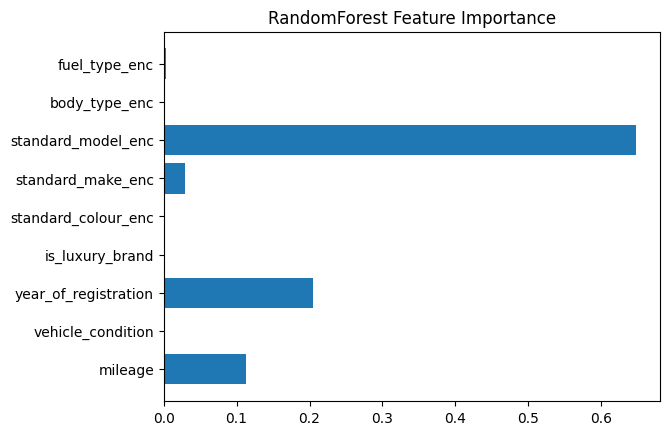

In [898]:
plt.barh(X_train.columns, random_forest.feature_importances_)
plt.title("RandomForest Feature Importance");

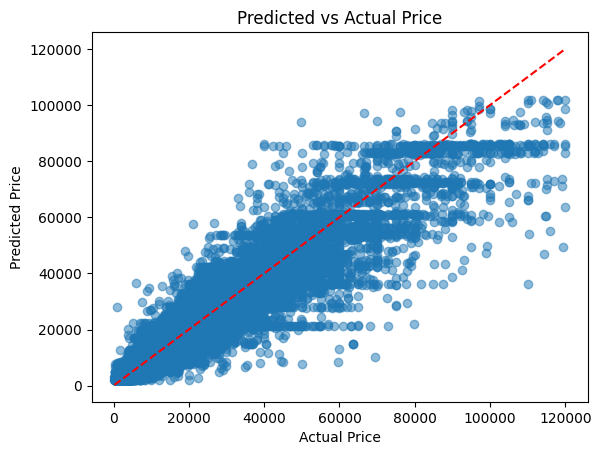

In [863]:
import matplotlib.pyplot as plt


plt.scatter(y_test, y_test_pred_random_forest, alpha=0.5)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'r--')
plt.xlabel('Actual Price')
plt.ylabel('Predicted Price')
plt.title('Predicted vs Actual Price')
plt.show()

## GradientBoost SKlearn (Too slow!) 

In [864]:
# from sklearn.ensemble import GradientBoostingRegressor

In [865]:
# gradient_boost = GradientBoostingRegressor(max_depth=7, verbose=1)
# gradient_boost.fit(X_train, y_train)

In [866]:
# y_train_pred_gradient_boost = gradient_boost.predict(X_train)
# y_test_pred_gradient_boost = gradient_boost.predict(X_test)

# model_names.append("GradientBoost")
# model_y_train_preds.append(y_train_pred_gradient_boost)
# model_y_test_preds.append(y_test_pred_gradient_boost)

# mean_absolute_error(y_train, y_train_pred_gradient_boost).round(2), r2_score(
#     y_train, y_train_pred_gradient_boost
# ).round(4),mean_absolute_error(y_test, y_test_pred_gradient_boost).round(2), r2_score(
#     y_test, y_test_pred_gradient_boost
# ).round(4)

In [867]:
# feature_importances_gradient_boost_df = pd.DataFrame(
#     data=gradient_boost.feature_importances_, columns=["importance"]
# )
# feature_importances_gradient_boost_df["name"] = feature_names
# feature_importances_gradient_boost_df.set_index("name").sort_values(
#     "importance", ascending=False
# ).head()

In [868]:
# plt.bar(
#     feature_importances_gradient_boost_df["name"],
#     feature_importances_gradient_boost_df["importance"],
# )
# plt.title("GradientBoost Feature Importance");
# plt.xticks(rotation=90);

## XGBOOST (GradientBoost but Fast!)

In [905]:
from xgboost import XGBRegressor
xg_boost = XGBRegressor(max_depth=7,n_jobs=8)
xg_boost.fit(X_train, y_train,verbose=1);

In [872]:
y_train_pred_xg_boost = xg_boost.predict(X_train)
y_test_pred_xg_boost = xg_boost.predict(X_test)

model_names.append("XGBoost")
model_y_train_preds.append(y_train_pred_xg_boost)
model_y_test_preds.append(y_test_pred_xg_boost)

print_scores(y_train,y_test,y_train_pred_xg_boost,y_test_pred_xg_boost)

train:
MAE: 1673.0 R2: 0.956 RMSE: 2839.0
test:
MAE: 1760.8 R2: 0.947 RMSE: 3133.5


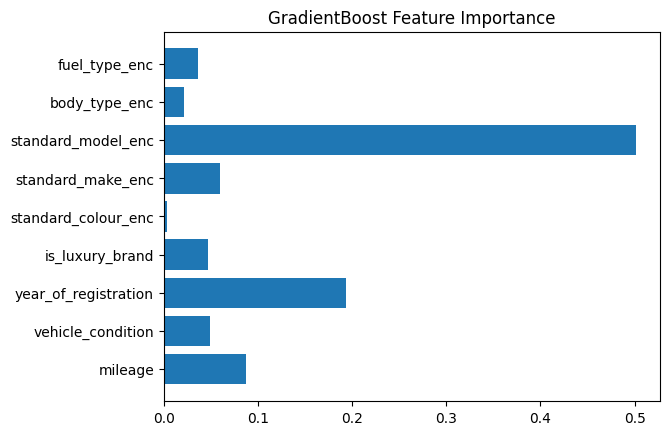

In [902]:
plt.barh(
    X_train.columns,
    xg_boost.feature_importances_,
)
plt.title("GradientBoost Feature Importance");


In [480]:
xg_boost.set_params(n_jobs=-1)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=7, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=-1,
             num_parallel_tree=None, random_state=None, ...)

In [481]:
explainer = shap.Explainer(xg_boost, X_train)

In [482]:
X_test

,mileage,vehicle_condition,year_of_registration,is_luxury_brand,standard_colour_enc,standard_make_enc,standard_model_enc,body_type_enc,fuel_type_enc
30606,1.250106,-0.292871,-0.172052,-0.121368,-0.298504,2.532624,3.618182,1.159013,0.189247
241740,-1.049219,-0.292871,0.817442,-0.121368,0.728486,0.469262,1.400439,1.159013,-0.558224
289071,-0.694843,-0.292871,0.817442,-0.121368,-0.089123,0.469262,0.129095,-0.080082,-0.558224
384080,0.703089,-0.292871,-0.666799,-0.121368,-1.640446,-0.604533,-0.646992,-1.067858,3.078586
50260,0.885428,-0.292871,-0.914173,-0.121368,-1.640446,-0.774879,-1.264778,-1.067858,-0.558224
...,...,...,...,...,...,...,...,...,...
262555,-0.491535,-0.292871,0.322695,-0.121368,-1.496953,-1.027484,-0.778016,-1.067858,-0.558224
49637,0.186462,-0.292871,0.322695,-0.121368,-1.496953,2.532624,0.844578,1.159013,0.189247
252215,0.312246,-0.292871,-0.666799,-0.121368,-1.640446,-0.374525,0.240235,1.159013,0.189247
250320,0.247242,-0.292871,-0.419426,-0.121368,0.728486,-0.604533,-0.887120,-1.067858,-0.558224


In [483]:
X_test_sampled = X_test.sample(frac = 0.1,random_state=42)
y_test_sampled = y_test.sample(frac = 0.1,random_state=42)

In [484]:
explanations = explainer(X_test_sampled,check_additivity=False)

 97%|=================== | 7522/7781 [00:23<00:00]       

In [485]:
explanations.shape

(7781, 9)

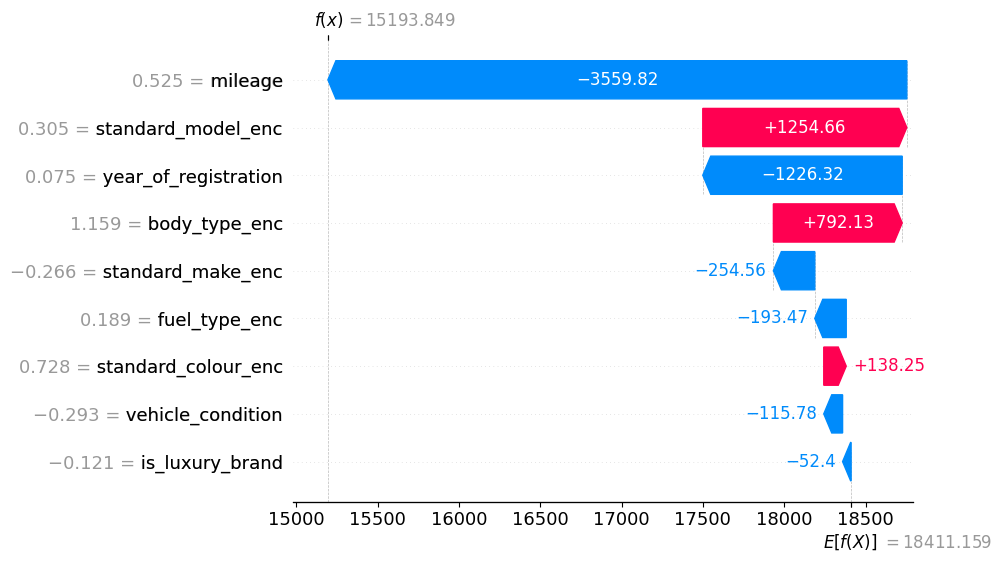

In [486]:
shap.plots.waterfall(explanations[0])

In [487]:
shap.initjs()
shap.plots.force(explanations[0])

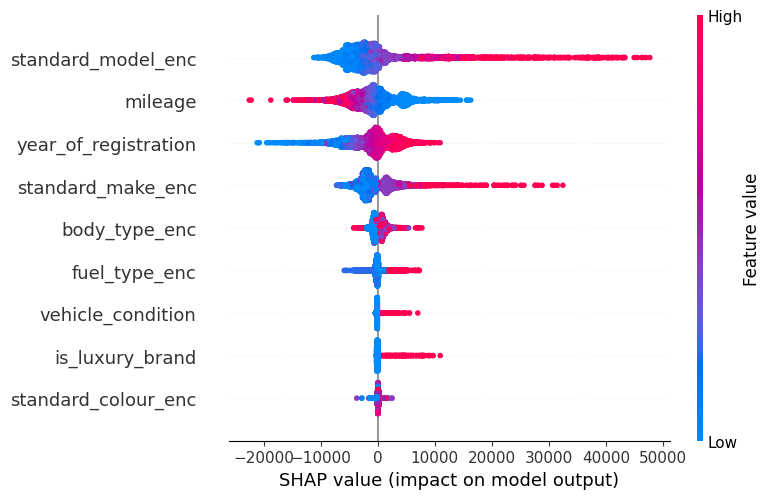

In [488]:
shap.summary_plot(explanations[:])

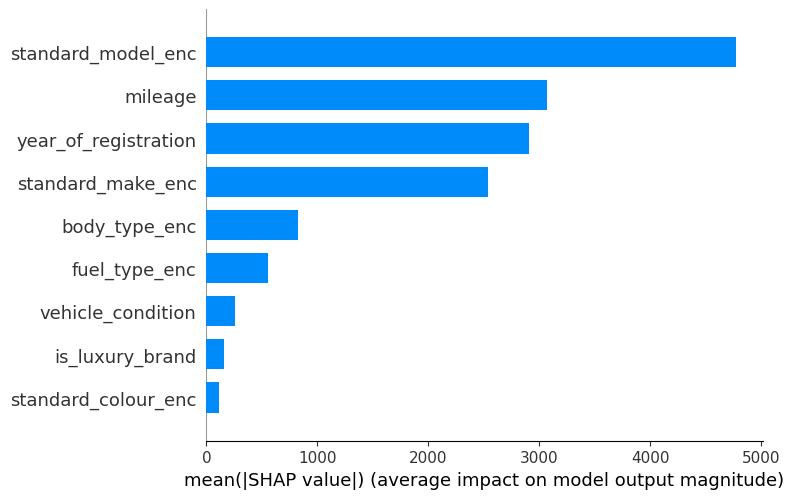

In [489]:
shap.summary_plot(explanations[:], plot_type="bar")

In [490]:
inverse_scaled_X_test_sampled = scaler.inverse_transform(X_test_sampled)

In [491]:
inverse_scaled_X_test_sampled = pd.DataFrame(inverse_scaled_X_test_sampled,columns=X_test_sampled.columns)

In [492]:
inverse_scaled_X_test_sampled.head()

,mileage,vehicle_condition,year_of_registration,is_luxury_brand,standard_colour_enc,standard_make_enc,standard_model_enc,body_type_enc,fuel_type_enc
0,54124.0,0.0,2016.0,0.0,17524.106043,14031.323556,19296.627064,22164.418735,16658.160340
1,16500.0,0.0,2019.0,0.0,17524.106043,11022.547694,9894.416870,18615.525598,16658.160340
2,87000.0,0.0,2007.0,0.0,18781.689267,8375.614785,5911.578642,10476.329786,14379.142658
3,33180.0,0.0,2014.0,0.0,13116.055085,14031.323556,14233.091225,10476.329786,14379.142658
4,58000.0,0.0,2016.0,0.0,12831.830876,12571.431122,14964.025396,22164.418735,16658.160340


In [493]:
explanations.data = inverse_scaled_X_test_sampled.to_numpy()

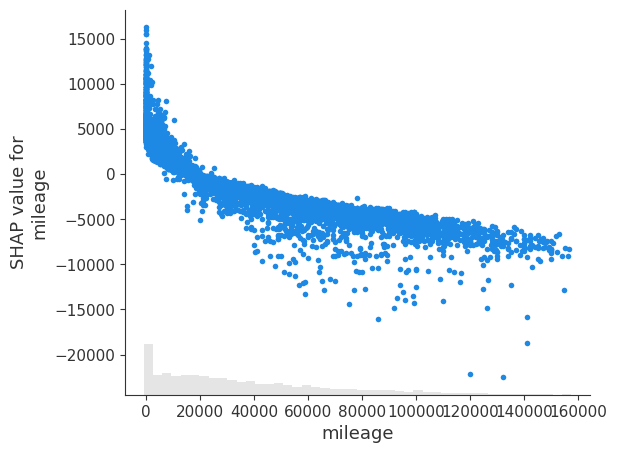

In [494]:
shap.plots.scatter(explanations[:, 'mileage'])

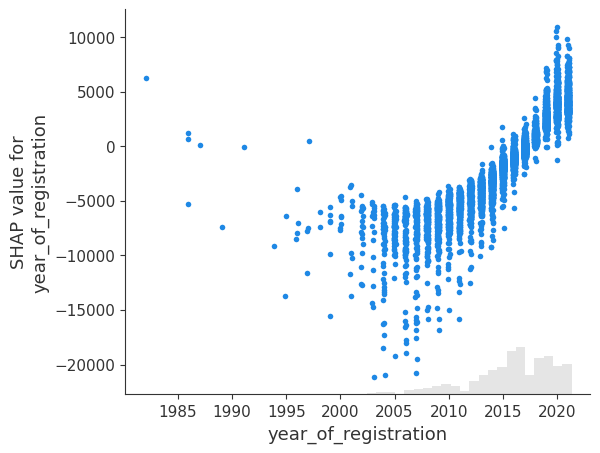

In [495]:
shap.plots.scatter(explanations[:, 'year_of_registration'])

In [496]:
explanations[0].data

array([54124.        ,     0.        ,  2016.        ,     0.        ,
       17524.10604275, 14031.32355572, 19296.62706404, 22164.41873493,
       16658.16033957])

In [497]:
for i in reverse_encode_maps:
    temp = {v: k for k, v in reverse_encode_maps[i].items()}
    reverse_encode_maps[i] = temp

In [498]:
encoded_data = pd.DataFrame(explanations.data,columns=X_train.columns)

In [499]:
encoded_data

,mileage,vehicle_condition,year_of_registration,is_luxury_brand,standard_colour_enc,standard_make_enc,standard_model_enc,body_type_enc,fuel_type_enc
0,54124.0,0.0,2016.0,0.0,17524.106043,14031.323556,19296.627064,22164.418735,16658.160340
1,16500.0,0.0,2019.0,0.0,17524.106043,11022.547694,9894.416870,18615.525598,16658.160340
2,87000.0,0.0,2007.0,0.0,18781.689267,8375.614785,5911.578642,10476.329786,14379.142658
3,33180.0,0.0,2014.0,0.0,13116.055085,14031.323556,14233.091225,10476.329786,14379.142658
4,58000.0,0.0,2016.0,0.0,12831.830876,12571.431122,14964.025396,22164.418735,16658.160340
...,...,...,...,...,...,...,...,...,...
7776,7048.0,0.0,2018.0,0.0,16072.789835,20907.228339,17627.479079,10476.329786,16658.160340
7777,19195.0,0.0,2014.0,0.0,15489.889288,11425.355141,9242.716358,10476.329786,25467.672738
7778,52710.0,0.0,2014.0,0.0,18781.689267,11524.412941,10388.240509,22164.418735,14379.142658
7779,0.0,1.0,2021.0,0.0,16072.789835,35583.764032,25000.745356,22164.418735,16658.160340


In [500]:
encoded_data=encoded_data.round(1)

In [501]:
cols_to_reverse = ["standard_colour_enc",	"standard_make_enc",	"standard_model_enc",	"body_type_enc",	"fuel_type_enc"]

for i in cols_to_reverse:
    encoded_data[i[:-4]] = encoded_data[i].replace(to_replace=reverse_encode_maps[i[:-4]].keys(),value=reverse_encode_maps[i[:-4]].values())

for i in cols_to_reverse:
    encoded_data[i]=encoded_data[i[:-4]]


In [502]:
encoded_data = encoded_data.drop(columns=(i[:-4] for i in cols_to_reverse))

In [503]:
# encoded_data['vehicle_condition'] = encoded_data['vehicle_condition'].replace({0:"USED",1:"NEW"})

In [504]:
explanations.data = encoded_data.to_numpy()

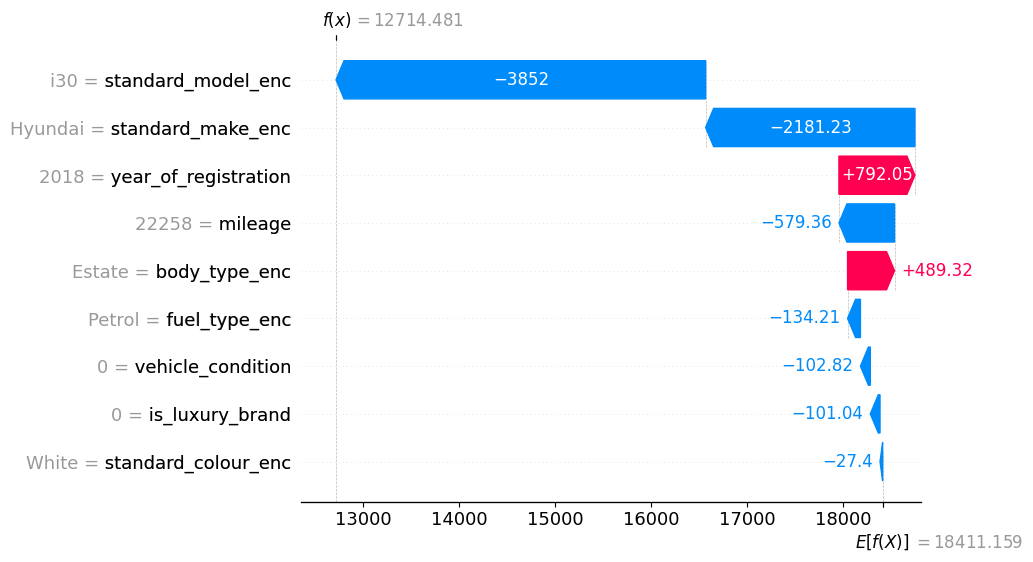

In [505]:
shap.plots.waterfall(explanations[5])

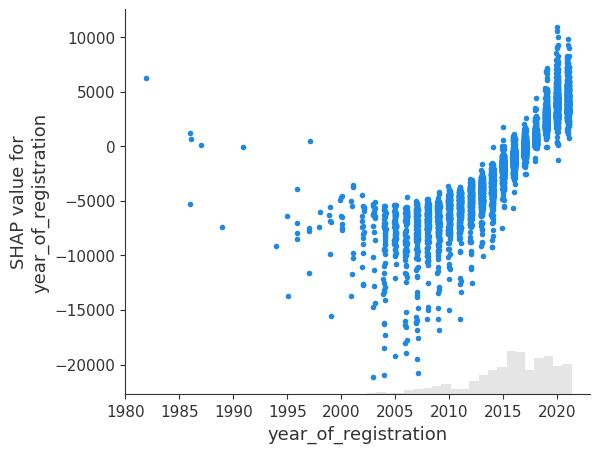

In [506]:
shap.plots.scatter(explanations[:, 'year_of_registration'])

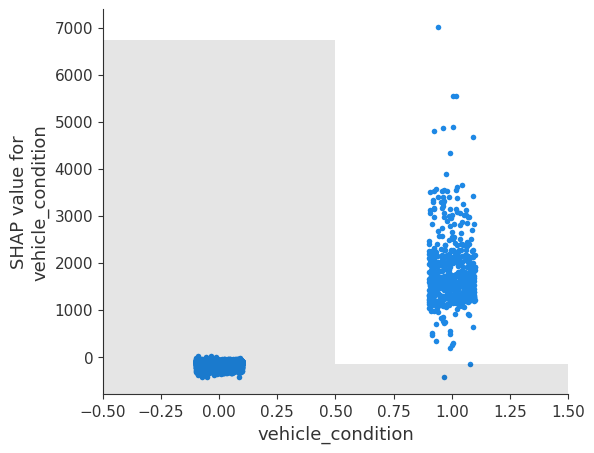

In [507]:
shap.plots.scatter(explanations[:, 'vehicle_condition'])

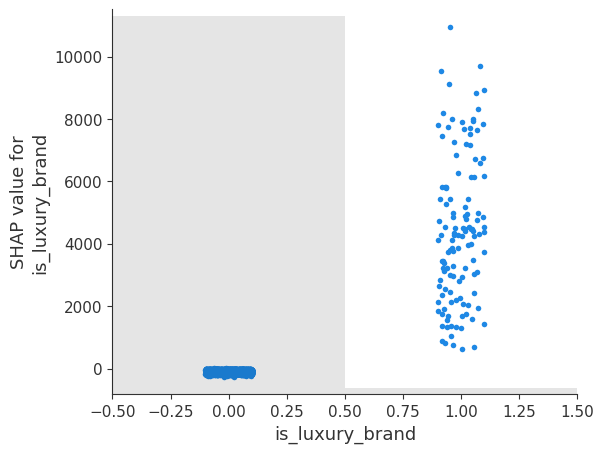

In [508]:
shap.plots.scatter(explanations[:, 'is_luxury_brand'])

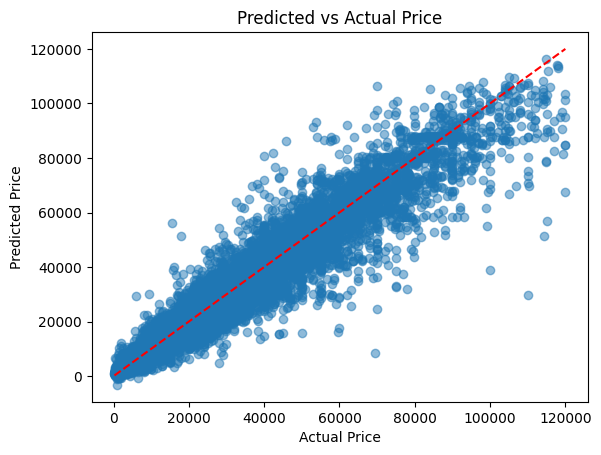

In [509]:
import matplotlib.pyplot as plt

plt.scatter(y_test, y_test_pred_xg_boost, alpha=0.5)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'r--')
plt.xlabel('Actual Price')
plt.ylabel('Predicted Price')
plt.title('Predicted vs Actual Price')
plt.show()

In [510]:
X_test_w_preds = scaler.inverse_transform(X_test)
X_test_w_preds = pd.DataFrame(X_test_w_preds,columns=X_test.columns)

X_test_w_preds = X_test_w_preds.reset_index()

X_test_w_preds=X_test_w_preds.round(1)
cols_to_reverse = ["standard_colour_enc",	"standard_make_enc",	"standard_model_enc",	"body_type_enc",	"fuel_type_enc"]

for i in cols_to_reverse:
    X_test_w_preds[i[:-4]] = X_test_w_preds[i].replace(to_replace=reverse_encode_maps[i[:-4]].keys(),value=reverse_encode_maps[i[:-4]].values())

for i in cols_to_reverse:
    X_test_w_preds[i]=X_test_w_preds[i[:-4]]

X_test_w_preds = X_test_w_preds.drop(columns=(i[:-4] for i in cols_to_reverse))

In [511]:
X_test_w_preds = pd.concat([X_test_w_preds,pd.Series(y_test_pred_xg_boost),y_test.reset_index()],axis=1).drop(columns=['index']).rename(columns={0:"pred_price"})
X_test_w_preds['pred_price']=X_test_w_preds['pred_price'].astype(np.int64)
X_test_w_preds

,mileage,vehicle_condition,year_of_registration,is_luxury_brand,standard_colour_enc,standard_make_enc,standard_model_enc,body_type_enc,fuel_type_enc,pred_price,price
0,78000.0,0.0,2015.0,0.0,Other,Land Rover,Range Rover,SUV,Diesel,31622,31950
1,2339.0,0.0,2019.0,0.0,Black,BMW,X2,SUV,Petrol,38796,31995
2,14000.0,0.0,2019.0,0.0,Blue,BMW,Z4,Other,Petrol,26769,36977
3,60000.0,0.0,2013.0,0.0,Silver,Toyota,Yaris,Hatchback,Hybrid,6928,7450
4,66000.0,0.0,2012.0,0.0,Silver,Peugeot,107,Hatchback,Petrol,2881,2495
...,...,...,...,...,...,...,...,...,...,...,...
77805,20690.0,0.0,2017.0,0.0,Red,Vauxhall,Astra,Hatchback,Petrol,9817,9799
77806,43000.0,0.0,2017.0,0.0,Red,Land Rover,Range Rover Evoque,SUV,Diesel,23006,21990
77807,47139.0,0.0,2013.0,0.0,Silver,Mazda,CX-5,SUV,Diesel,9194,8995
77808,45000.0,0.0,2014.0,0.0,Black,Toyota,AYGO,Hatchback,Petrol,5088,5790


In [512]:
X_test_w_preds['error'] = X_test_w_preds['pred_price']/X_test_w_preds['price']
X_test_w_preds['error'].describe()

count    77810.000000
mean         1.032982
std          0.226415
min         -3.240201
25%          0.927465
50%          1.013037
75%          1.109777
max         19.028571
Name: error, dtype: float64

In [513]:
X_test_w_preds['error_abs'] = abs(X_test_w_preds['error']) 

In [514]:
ERROR_THRESHOLD_QUANTILE = X_test_w_preds['error_abs'].quantile(.95)

X_test_high_error_decoded = X_test_w_preds[X_test_w_preds['error_abs']>ERROR_THRESHOLD_QUANTILE]
X_test_high_error_decoded.describe()

,mileage,vehicle_condition,year_of_registration,is_luxury_brand,pred_price,price,error,error_abs
count,3891.000000,3891.000000,3891.000000,3891.000000,3891.000000,3891.000000,3891.000000,3891.000000
mean,62863.508353,0.025443,2011.277307,0.024415,10799.811360,7320.301208,1.599353,1.601018
std,38773.258083,0.157488,5.496804,0.154355,12962.220811,8939.413643,0.574315,0.569655
min,0.000000,0.000000,1982.000000,0.000000,-3224.000000,250.000000,-3.240201,1.316800
25%,30368.500000,0.000000,2007.000000,0.000000,3085.000000,1990.000000,1.361804,1.361909
50%,63000.000000,0.000000,2011.000000,0.000000,6342.000000,4200.000000,1.447236,1.447273
75%,91000.000000,0.000000,2016.000000,0.000000,13326.500000,9194.500000,1.628810,1.628944
max,157500.000000,1.000000,2021.000000,1.000000,106327.000000,75370.000000,19.028571,19.028571


## PDP and ICE

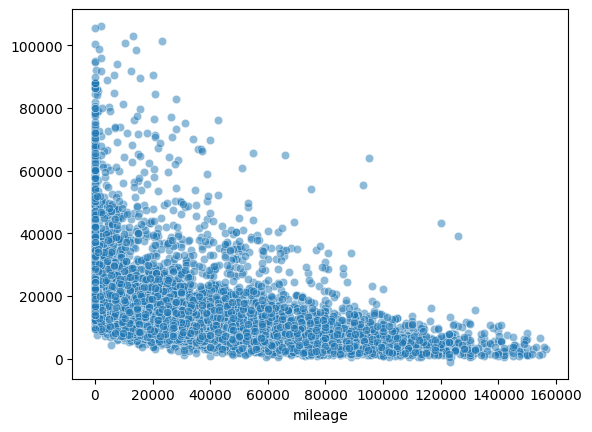

In [515]:
sns.scatterplot(x=encoded_data['mileage'], y=xg_boost.predict(X_test_sampled), alpha=0.5);

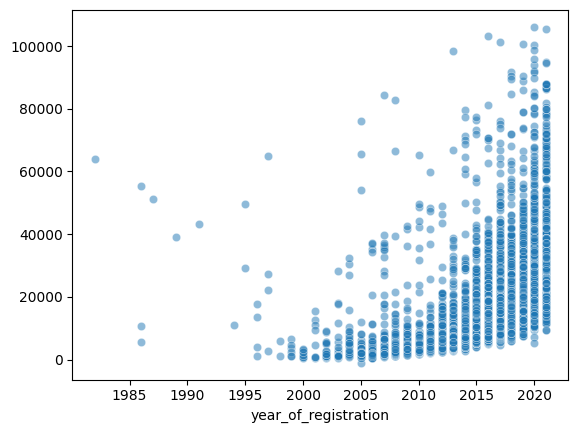

In [516]:
sns.scatterplot(x=encoded_data['year_of_registration'], y=xg_boost.predict(X_test_sampled), alpha=0.5);

In [517]:
from sklearn.inspection import PartialDependenceDisplay



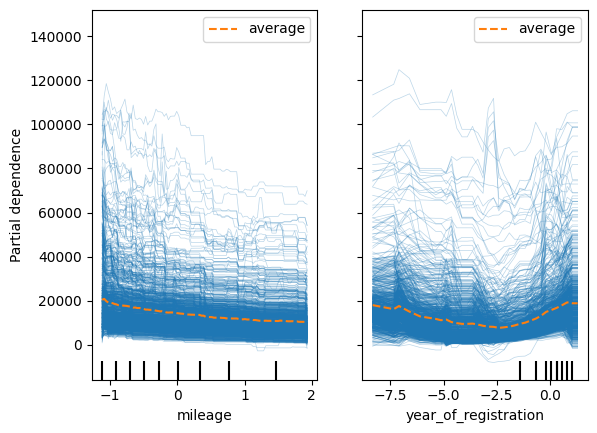

In [518]:
PartialDependenceDisplay.from_estimator(
    xg_boost, X_test_sampled, features=['mileage','year_of_registration'], kind='both',n_jobs=1
);

## 4.1 Linear Regression


In [875]:
linear_regression = LinearRegression()
linear_regression.fit(X_train, y_train);

In [876]:
y_train_pred_linear_regression = linear_regression.predict(X_train)
y_test_pred_linear_regression = linear_regression.predict(X_test)

model_names.append("LinearRegression")
model_y_train_preds.append(y_train_pred_linear_regression)
model_y_test_preds.append(y_test_pred_linear_regression)

print_scores(y_train,y_test,y_train_pred_linear_regression,y_test_pred_linear_regression)

train:
MAE: 3849.4 R2: 0.795 RMSE: 6165.9
test:
MAE: 3849.1 R2: 0.795 RMSE: 6156.3


In [167]:
# show top 5 most important features and prepare the data for visualisation

feature_importances_linear_df = pd.DataFrame(
    data=linear_regression.coef_, columns=["importance"]
)
feature_importances_linear_df["name"] = feature_names
feature_importances_linear_df.set_index("name").sort_values(
    "importance", ascending=False
).head()

,importance
name,
standard_model_enc,8041.747270
year_of_registration,2488.307170
standard_make_enc,1733.470041
vehicle_condition,1721.557123
fuel_type_enc,486.503304


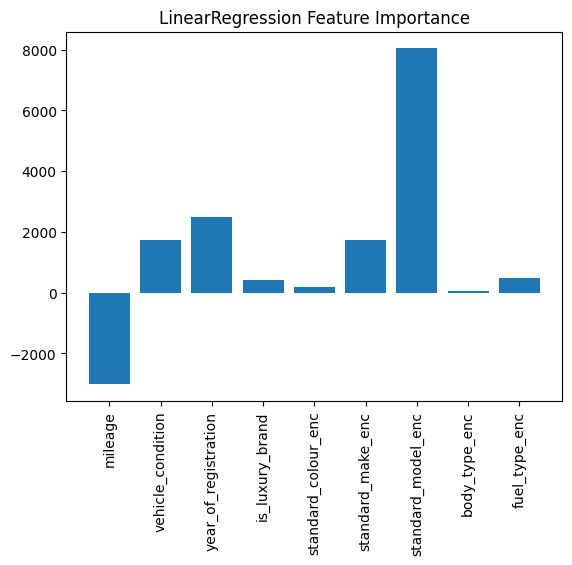

In [168]:
plt.bar(
    feature_importances_linear_df["name"], feature_importances_linear_df["importance"]
)
plt.title("LinearRegression Feature Importance");
plt.xticks(rotation=90);

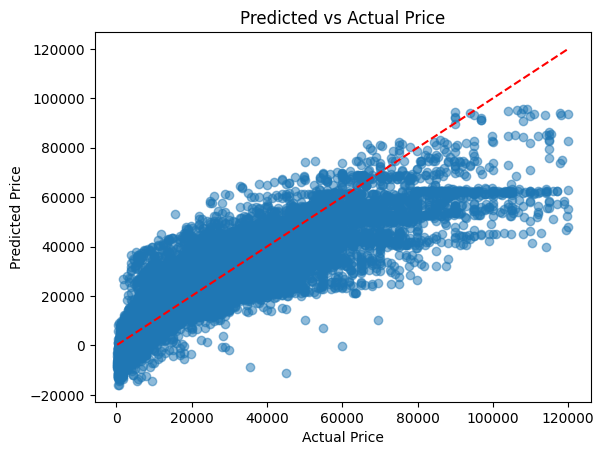

In [169]:
plt.scatter(y_test, y_test_pred_linear_regression, alpha=0.5)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'r--')
plt.xlabel('Actual Price')
plt.ylabel('Predicted Price')
plt.title('Predicted vs Actual Price')
plt.show()

## LR with Interaction Features

In [737]:
model_before_kbest = LinearRegression().fit(X_train_poly, y_train)
scores_before_kbest = cross_val_score(model_before_kbest, X_train_poly, y_train)
print("(R2, std) LR W/ Poly Before Kbest: ",scores_before_kbest.mean().round(5), scores_before_kbest.std().round(5))
model_after_kbest = LinearRegression().fit(X_train_poly_kbest_selected, y_train)
scores_after_kbest = cross_val_score(model_after_kbest, X_train_poly_kbest_selected, y_train)
print("(R2, std) LR W/ Poly After Kbest : ",scores_after_kbest.mean().round(5), scores_after_kbest.std().round(5))

(R2, std) LR W/ Poly Before Kbest:  0.85956 0.00163
(R2, std) LR W/ Poly After Kbest :  0.84231 0.00144


In [ ]:
y_train_pred_linear_regression_w_poly = model_before_kbest.predict(X_train_poly)
y_test_pred_linear_regression_w_poly = model_before_kbest.predict(X_test_poly)
y_train_pred_poly_kbest = model_after_kbest.predict(X_train_poly_kbest_selected)
y_test_pred_poly_kbest = model_after_kbest.predict(X_test_poly_kbest_selected)

model_names.append("LR W/ Poly")
model_y_train_preds.append(y_train_pred_linear_regression_w_poly)
model_y_test_preds.append(y_test_pred_linear_regression_w_poly)
model_names.append("LR W/ Poly & Kbest")
model_y_train_preds.append(y_train_pred_poly_kbest)
model_y_test_preds.append(y_test_pred_poly_kbest)


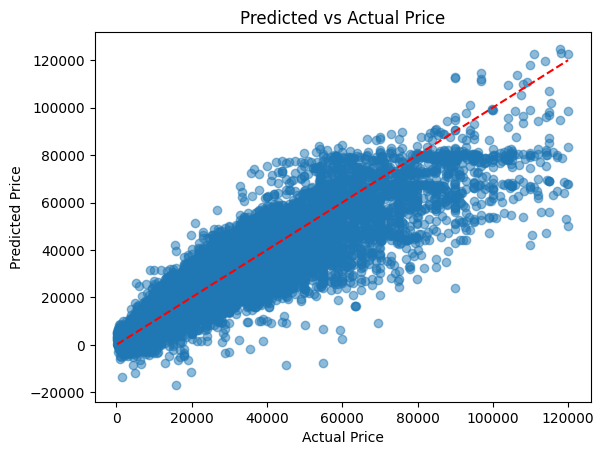

In [738]:

plt.scatter(y_test, y_test_pred_linear_regression_w_poly, alpha=0.5)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'r--')
plt.xlabel('Actual Price')
plt.ylabel('Predicted Price')
plt.title('Predicted vs Actual Price')
plt.show()

### Dimensionatlity Reduction using PCA

In [244]:
from sklearn.decomposition import PCA
pca = PCA(random_state=42)
pca.fit(X_train_poly_kbest_selected)

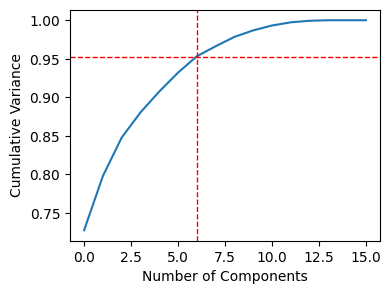

In [263]:
fig = plt.figure(figsize = (4,3))
evr = pca.explained_variance_ratio_
plt.plot(np.cumsum(evr))

plt.xlabel('Number of Components')
plt.ylabel('Cumulative Variance')
plt.axhline(y = 0.952, color='red', linestyle='dashed', linewidth=1)
plt.axvline(x = 6, color='red', linestyle='dashed', linewidth=1);

In [260]:
pca_6 = PCA(n_components=6).set_output(transform="pandas")
X_train_poly_kbest_selected_pca = pca_6.fit_transform(X_train_poly_kbest_selected)

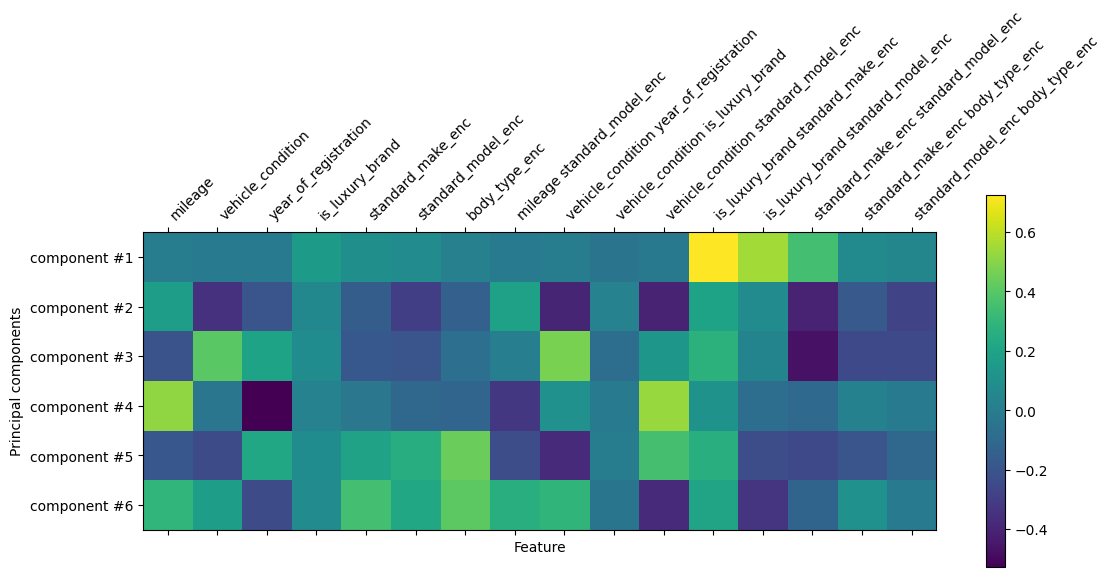

In [261]:
plt.matshow(pca_6.components_, cmap='viridis')
plt.yticks([i for i in range(6)], ["component #"+str(i+1) for i in range(6)])
plt.colorbar()
plt.xticks(range(len(X_train_poly_kbest_selected.columns)),
           X_train_poly_kbest_selected.columns, rotation=45, ha='left')
plt.xlabel("Feature")
plt.ylabel("Principal components");

In [262]:
model_before_pca = LinearRegression().fit(X_train_poly_kbest_selected, y_train)
scores_before_pca = cross_val_score(model_before_pca, X_train_poly_kbest_selected, y_train)
print("(R2, std) Before: ",scores_before_pca.mean().round(5), scores_before_pca.std().round(5))
model_after_pca = LinearRegression().fit(X_train_poly_kbest_selected_pca, y_train)
scores_after_pca = cross_val_score(model_after_pca, X_train_poly_kbest_selected_pca, y_train)
print("(R2, std) After : ",scores_after_pca.mean().round(5), scores_after_pca.std().round(5))

(R2, std) Before:  0.84231 0.00144
(R2, std) After :  0.76847 0.00204


## GridSearch for XGBoost Fine_tuning

In [917]:
param_grid_rf = {
    "n_estimators": [120, 150, 200],
    "max_depth": [5, 7,11],
    "max_leaves":[0,3],
    "grow_policy":['depthwise', 'lossguide'],
    "min_child_weight":[1,3],
    "learning_rate":[0.1,0.3],}
xgboost_gs = XGBRegressor(n_jobs=1)
from sklearn.model_selection import ParameterGrid
len(list(ParameterGrid(param_grid_rf)))

144

In [ ]:
from sklearn.model_selection import GridSearchCV
gs_xgboost = GridSearchCV(xgboost_gs, param_grid_rf,cv=5, return_train_score=True,n_jobs=8)
gs_results_rf = gs_xgboost.fit(X_train, y_train)
gs_df_rf = pd.DataFrame(gs_results_rf.cv_results_)

In [921]:
gs_df_rf.sort_values('mean_test_score',ascending=False).head(1)[['mean_test_score','mean_train_score']]

,mean_test_score,mean_train_score
27,0.946508,0.970795


# ENSEMBLE MODEL

In [927]:
from sklearn.ensemble import VotingRegressor,StackingRegressor
voting_regressor = VotingRegressor([('lr',linear_regression ), ('rf', random_forest), ('xgb', xg_boost)],n_jobs=1)
voting_regressor.fit(X_train, y_train)

y_train_pred_voting = voting_regressor.predict(X_train)
y_test_pred_voting = voting_regressor.predict(X_test)

model_names.append("Voting Ensemble")
model_y_train_preds.append(y_train_pred_voting)
model_y_test_preds.append(y_test_pred_voting)

print_scores(y_train,y_test,y_train_pred_voting,y_test_pred_voting)


train:
MAE: 2382.3 R2: 0.916 RMSE: 3934.2
test:
MAE: 2413.4 R2: 0.913 RMSE: 4023.7


In [932]:

stacking_regressor = StackingRegressor(estimators=[('lr',linear_regression ), ('rf', random_forest), ('xgb', xg_boost)],n_jobs=8,cv=5)
stacking_regressor.fit(X_train,y_train)

y_train_pred_stacking = stacking_regressor.predict(X_train)
y_test_pred_stacking = stacking_regressor.predict(X_test)

model_names.append("Stacking Ensemble")
model_y_train_preds.append(y_train_pred_stacking)
model_y_test_preds.append(y_test_pred_stacking)

print_scores(y_train,y_test,y_train_pred_stacking,y_test_pred_stacking)

train:
MAE: 2850.2 R2: 0.905 RMSE: 4194.5
test:
MAE: 2910.0 R2: 0.895 RMSE: 4402.0


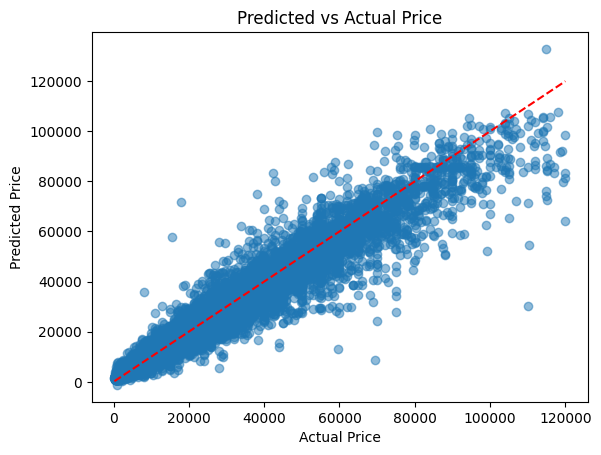

In [493]:

plt.scatter(y_test, y_test_pred_stacking, alpha=0.5)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'r--')
plt.xlabel('Actual Price')
plt.ylabel('Predicted Price')
plt.title('Predicted vs Actual Price')
plt.show()

# Comparing models


In [496]:
model_train_mae_scores = []
model_test_mae_scores = []
model_test_r2_scores = []
for i in range(len(model_names)):
    model_train_mae_scores.append(mean_absolute_error(y_train, model_y_train_preds[i]).round(2))
    model_test_mae_scores.append(mean_absolute_error(y_test, model_y_test_preds[i]).round(2))  
    model_test_r2_scores.append(r2_score(y_test, model_y_test_preds[i]).round(2))  
    print(model_names[i],":")
    print(
        "RMSE :",
        root_mean_squared_error(y_test, model_y_test_preds[i]).round(2),
        "MAE :",
        mean_absolute_error(y_test, model_y_test_preds[i]).round(2),
        "R^2 :",
        r2_score(y_test, model_y_test_preds[i]).round(4),
    )

Neural Net (MLPR) :
RMSE : 4975.18 MAE : 2898.77 R^2 : 0.8652
RandomForest :
RMSE : 4554.34 MAE : 2781.81 R^2 : 0.887
XGBoost :
RMSE : 3127.64 MAE : 1768.75 R^2 : 0.9467
LinearRegression :
RMSE : 6141.57 MAE : 3844.23 R^2 : 0.7945
LR With Interactions :
RMSE : 5063.33 MAE : 3019.8 R^2 : 0.8603
Voting Ensemble :
RMSE : 4020.19 MAE : 2409.14 R^2 : 0.912
Stacking Ensemble :
RMSE : 3157.33 MAE : 1799.73 R^2 : 0.9457


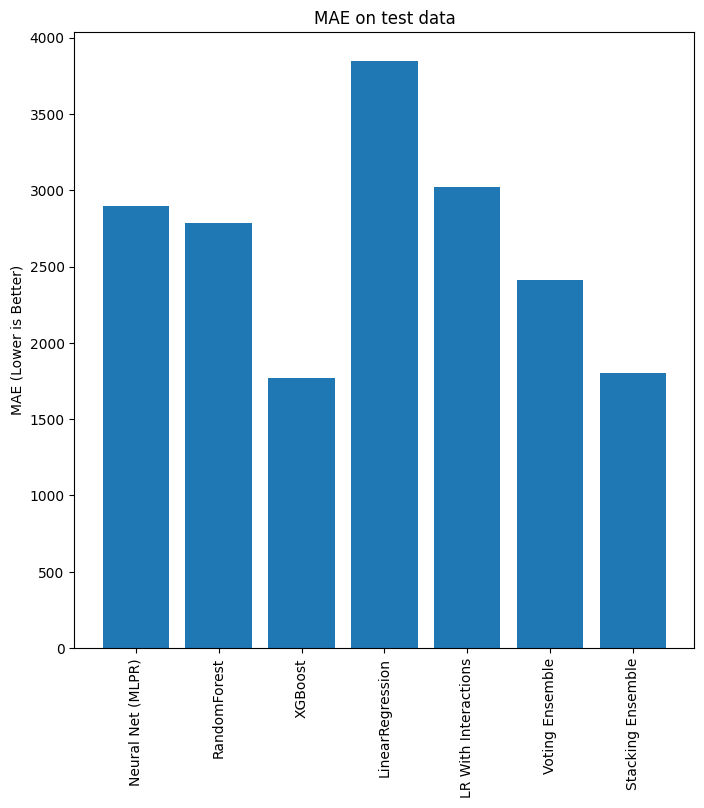

In [497]:
plt.figure(figsize=(8,8));
plt.bar(model_names,model_test_mae_scores)
plt.title("MAE on test data");
plt.xticks(rotation=90);
plt.ylabel('MAE (Lower is Better)');


(0.75, 1.0)

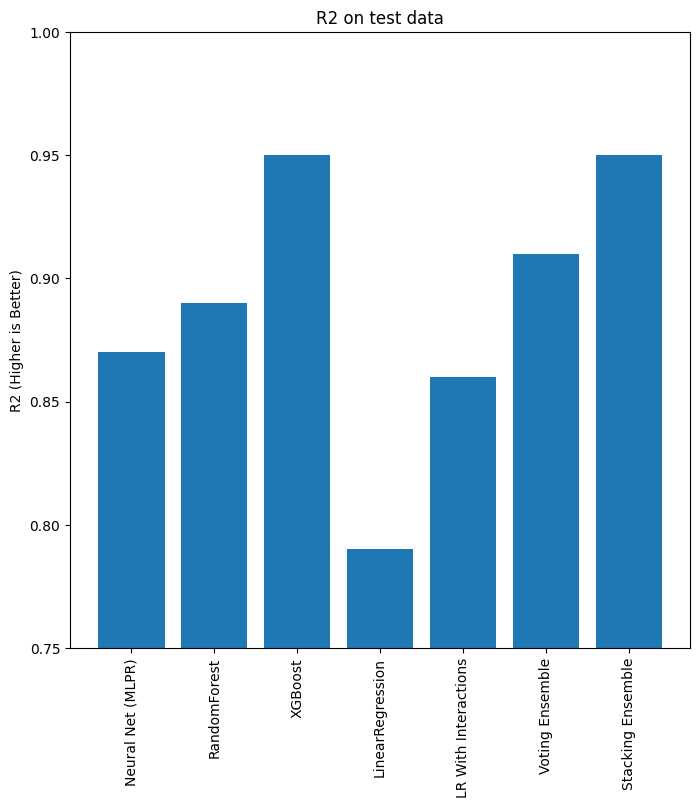

In [508]:
plt.figure(figsize=(8,8));
plt.bar(model_names,model_test_r2_scores)
plt.title("R2 on test data");
plt.xticks(rotation=90);
plt.ylabel('R2 (Higher is Better)');
plt.ylim((.75,1))

## BASELINE PERFORMANCE

In [312]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder,LabelEncoder
from sklearn.compose import ColumnTransformer

from sklearn.model_selection import cross_validate


In [313]:
scaler = StandardScaler()

In [378]:
numeric_transformer = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="mean")),
        ("scaling",scaler)
    ],verbose=True
)

In [379]:
categorical_transformer = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("encoder", TargetEncoder()),
        ("scaling",scaler)
    ],verbose=True
)

In [380]:
# model_transformer = Pipeline(
#     steps=[
#         ("imputer",SimpleImputer(strategy="most_frequent")),
#         ("encoder",OrdinalEncoder()),
#     ],verbose=True

# )

In [381]:
raw_data = pd.read_csv('adverts.csv').drop(columns='public_reference')

In [382]:
X_pipe = raw_data.drop(columns=['price'])

In [383]:
y_pipe = raw_data['price']

In [384]:
num_feats = X_pipe.select_dtypes(exclude="object").columns
cat_feats = X_pipe.select_dtypes("object").columns

num_feats,cat_feats

(Index(['mileage', 'year_of_registration', 'crossover_car_and_van'], dtype='object'),
 Index(['reg_code', 'standard_colour', 'standard_make', 'standard_model',
        'vehicle_condition', 'body_type', 'fuel_type'],
       dtype='object'))

In [385]:
preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, num_feats),
        ("cat_rest", categorical_transformer, cat_feats),
        
        
        # ("cat_model", model_transformer, ['standard_model','standard_make']),
    ],verbose=True
)
preprocessor

ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('imputer', SimpleImputer()),
                                                 ('scaling', StandardScaler())],
                                          verbose=True),
                                 Index(['mileage', 'year_of_registration', 'crossover_car_and_van'], dtype='object')),
                                ('cat_rest',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('encoder', TargetEncoder()),
                                                 ('scaling', StandardScaler())],
                                          verbose=True),
                                 Index(['reg_code', 'standard_colour', 'standard_make', 'standard_model',
       'vehicle_condition', 'body_type', 'fuel_type'],
      dtype='object'))],
                  verbose=True)

In [386]:
rgr = Pipeline(
    steps=[
        ("pp",preprocessor),
        ("rgr",XGBRegressor(n_jobs=8))
    ],verbose=True
)
rgr

Pipeline(steps=[('pp',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaling',
                                                                   StandardScaler())],
                                                           verbose=True),
                                                  Index(['mileage', 'year_of_registration', 'crossover_car_and_van'], dtype='object')),
                                                 ('cat_rest',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoder',
                                                                   TargetEncoder()),
                                                                  ('scaling',...
                              feature_types=None, gamma=None, grow_policy=None,
                              importance_type=None,
                              interaction_constraints=None, learning_rate=None,
                              max_bin=None, max_cat_threshold=None,
                              max_cat_to_onehot=None, max_delta_step=None,
                              max_depth=None, max_leaves=None,
                              min_child_weight=None, missing=nan,
                              monotone_constraints=None, multi_strategy=None,
                              n_estimators=None, n_jobs=8,
                              num_parallel_tree=None, random_state=None, ...))],
         verbose=True)

In [387]:
raw_data

,mileage,reg_code,standard_colour,standard_make,standard_model,vehicle_condition,year_of_registration,price,body_type,crossover_car_and_van,fuel_type
0,0.0,NaN,Grey,Volvo,XC90,NEW,NaN,73970,SUV,False,Petrol Plug-in Hybrid
1,108230.0,61,Blue,Jaguar,XF,USED,2011.0,7000,Saloon,False,Diesel
2,7800.0,17,Grey,SKODA,Yeti,USED,2017.0,14000,SUV,False,Petrol
3,45000.0,16,Brown,Vauxhall,Mokka,USED,2016.0,7995,Hatchback,False,Diesel
4,64000.0,64,Grey,Land Rover,Range Rover Sport,USED,2015.0,26995,SUV,False,Diesel
...,...,...,...,...,...,...,...,...,...,...,...
402000,5179.0,69,Grey,Peugeot,208,USED,2019.0,10595,Hatchback,False,Petrol
402001,110000.0,59,Red,Peugeot,107,USED,2009.0,2000,Hatchback,False,Petrol
402002,52760.0,62,White,Nissan,Qashqai,USED,2012.0,7250,SUV,False,Petrol
402003,10250.0,65,Red,Abarth,595,USED,2015.0,11490,Hatchback,False,Petrol


In [388]:
rgr.fit(X_pipe,y_pipe)

[Pipeline] ........... (step 1 of 2) Processing imputer, total=   0.1s
[Pipeline] ........... (step 2 of 2) Processing scaling, total=   0.0s
[ColumnTransformer] ........... (1 of 2) Processing num, total=   0.1s
[Pipeline] ........... (step 1 of 3) Processing imputer, total=   0.2s
[Pipeline] ........... (step 2 of 3) Processing encoder, total=   1.1s
[Pipeline] ........... (step 3 of 3) Processing scaling, total=   0.0s
[ColumnTransformer] ...... (2 of 2) Processing cat_rest, total=   1.3s
[Pipeline] ................ (step 1 of 2) Processing pp, total=   1.4s
[Pipeline] ............... (step 2 of 2) Processing rgr, total=   0.7s


Pipeline(steps=[('pp',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaling',
                                                                   StandardScaler())],
                                                           verbose=True),
                                                  Index(['mileage', 'year_of_registration', 'crossover_car_and_van'], dtype='object')),
                                                 ('cat_rest',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoder',
                                                                   TargetEncoder()),
                                                                  ('scaling',...
                              feature_types=None, gamma=None, grow_policy=None,
                              importance_type=None,
                              interaction_constraints=None, learning_rate=None,
                              max_bin=None, max_cat_threshold=None,
                              max_cat_to_onehot=None, max_delta_step=None,
                              max_depth=None, max_leaves=None,
                              min_child_weight=None, missing=nan,
                              monotone_constraints=None, multi_strategy=None,
                              n_estimators=None, n_jobs=8,
                              num_parallel_tree=None, random_state=None, ...))],
         verbose=True)

In [401]:
eval_results = cross_validate(
    rgr, X_pipe, y_pipe, cv=5,
    scoring=['r2','neg_mean_absolute_error'],
    return_train_score=True,
    n_jobs=-1,
    
)

[Pipeline] ........... (step 1 of 2) Processing imputer, total=   0.1s
[Pipeline] ........... (step 2 of 2) Processing scaling, total=   0.0s
[ColumnTransformer] ........... (1 of 2) Processing num, total=   0.1s
[Pipeline] ........... (step 1 of 2) Processing imputer, total=   0.1s
[Pipeline] ........... (step 2 of 2) Processing scaling, total=   0.0s
[ColumnTransformer] ........... (1 of 2) Processing num, total=   0.1s
[Pipeline] ........... (step 1 of 2) Processing imputer, total=   0.1s
[Pipeline] ........... (step 2 of 2) Processing scaling, total=   0.0s
[ColumnTransformer] ........... (1 of 2) Processing num, total=   0.1s
[Pipeline] ........... (step 1 of 3) Processing imputer, total=   0.2s
[Pipeline] ........... (step 1 of 2) Processing imputer, total=   0.1s
[Pipeline] ........... (step 1 of 3) Processing imputer, total=   0.2s
[Pipeline] ........... (step 2 of 2) Processing scaling, total=   0.0s
[ColumnTransformer] ........... (1 of 2) Processing num, total=   0.1s
[Pipel

In [396]:
eval_results

{'fit_time': array([7.58196497, 7.38838792, 7.33842111, 7.5686748 , 7.55423689,
        7.3569169 , 7.17972994, 6.99817204]),
 'score_time': array([0.13204098, 0.12216377, 0.11293888, 0.16360211, 0.09258509,
        0.19400096, 0.17232513, 0.09703994]),
 'test_r2': array([ 0.72740513, -1.42155905, -0.06365492,  0.38080356,  0.74353573,
         0.19667294,  0.0831027 ,  0.10178385]),
 'train_r2': array([0.98349755, 0.98247601, 0.97279704, 0.98355028, 0.98077439,
        0.98015562, 0.9785237 , 0.97827265]),
 'test_neg_mean_absolute_error': array([-2523.27217192, -2734.55903497, -3124.96658063, -2614.87448694,
        -2514.53919457, -2795.28735752, -3075.01388416, -2741.26318192]),
 'train_neg_mean_absolute_error': array([-2309.32321858, -2287.69414856, -2297.91336453, -2298.78349933,
        -2299.72728707, -2324.41730395, -2259.15730007, -2340.1377299 ])}

In [397]:
feature_names = df.columns

In [398]:
feature_importances_df = pd.DataFrame(
    data=rgr['rgr'].feature_importances_, columns=["importance"]
)
feature_importances_df["name"] = X_pipe.columns
feature_importances_df.set_index("name").sort_values(
    "importance", ascending=False
)

,importance
name,
year_of_registration,0.518601
mileage,0.132638
vehicle_condition,0.110875
fuel_type,0.078070
reg_code,0.058679
crossover_car_and_van,0.042528
standard_make,0.027676
body_type,0.014563
standard_model,0.014065


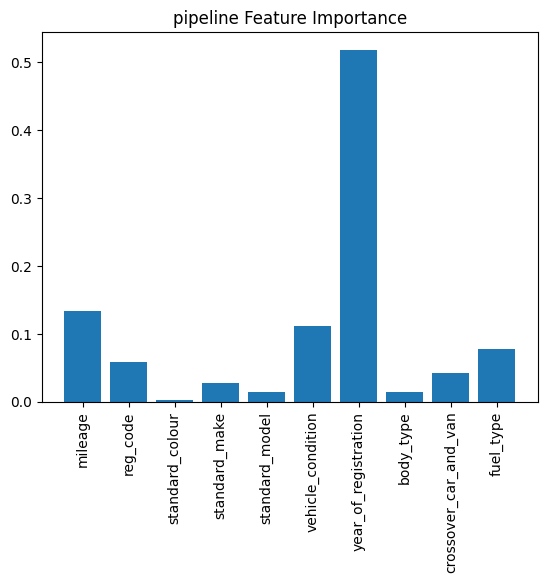

In [399]:
plt.bar(feature_importances_df["name"], feature_importances_df["importance"])
plt.title("pipeline Feature Importance");
plt.xticks(rotation=90);